# Required Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
import os
from archetypes import *
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

# Dictionaries required for plots

In [2]:
# RGB values for each region
region_color = {
    "Ocean": (0.2154516905067, 0.295, 0.5078367867510504),
    "Desert": (0.78, 0.51, 0.1892045842),
    "Biogenic": (0.12071162840208301, 0.4357915995132193, 0.2463679091477368),
    "Urban": (0.7, 0.7, 0.65),
    "Almost Polar": (0.5184891135337089, 0.7194769933793438, 0.7518803726887796),
    "Polar": (0.5632111255041908, 0.758620966612444, 0.7764634182455044)
}

# Region for each location
location_to_region = {
    'Amazon': 'Biogenic',
    'AtlanticOcean': 'Ocean',
    'Beijing': 'Urban',
    'Borneo': 'Biogenic',
    'CapeGrim': 'Polar',
    'Congo': 'Biogenic',
    'ElDjouf': 'Desert',
    'Graciosa': 'Ocean',
    'IndianOcean': 'Ocean',
    'Kinshasa': 'Urban',
    'LosAngeles': 'Urban',
    'McMurdo': 'Polar',
    'Ozarks': 'Biogenic',
    'PacificOcean': 'Ocean',
    'Paris': 'Urban',
    'Utqiagvik': 'Almost Polar'
}

# Parser - to parse each file in the dataset

In [6]:
class ChemicalCase:
    def __init__(self, filename):
        self.filename = filename
        self.parse_file()
        self.record = [self.timestamp, self.longitude, self.latitude, self.level, self.temperature, self.pressure, self.air_number_density, self.average_water, self.cloud_fraction, self.cos_sza, self.kpp_h_val, self.internal_timesteps 
] + self.concentrations + self.reaction_rates + self.rate_constants

    def parse_file(self):
        with open(self.filename, 'r') as f:
            lines = f.readlines()
            for i, line in enumerate(lines):
                if line.startswith('Meteorological Fields'):
                    self.parse_meteorological_fields(lines[i+1:])
                elif line.startswith('Integrator-specific parameters'):
                    self.parse_integrator_specific_parameters(lines[i+1:])
                elif line.startswith('Chemical state'):
                    self.parse_chemical_state(lines[i+1:])

    def parse_meteorological_fields(self, lines):
        self.timestamp = lines[0].split('Timestamp:')[1].strip()
        self.longitude = float(lines[1].split(':')[1].strip())
        self.latitude = float(lines[2].split(':')[1].strip())
        self.level = int(lines[3].split(':')[1].strip())
        self.temperature = float(lines[4].split(':')[1].strip())
        self.pressure = float(lines[5].split(':')[1].strip())
        self.air_number_density = float(lines[6].split(':')[1].strip())
        self.average_water = float(lines[7].split(':')[1].strip())
        self.cloud_fraction = float(lines[8].split(':')[1].strip())
        self.cos_sza = float(lines[9].split(':')[1].strip())

    def parse_integrator_specific_parameters(self, lines):
        self.kpp_h_val = float(lines[0].split(':')[1].strip())
        self.internal_timesteps = int(float(lines[0-1].split(':')[1].strip()))
    
    def parse_chemical_state(self, lines):
        # obin: Based on Emy's code for parsing all values
        self.concentrations = []
        self.rate_constants = []
        self.reaction_rates = []
        for line in lines:
            if line.startswith(' C('):
                parts = line.split('=')
                value = float(parts[1].strip())
                self.concentrations.append(value)
            elif line.startswith(' R('):
                parts = line.split('=')
                value = float(parts[1].strip())
                self.rate_constants.append(value)
            elif line.startswith(' A('):
                parts = line.split('=')
                value = float(parts[1].strip())
                self.reaction_rates.append(value)

# Custom function to plot - Simplex Plot

In [4]:
#For categorical
# categorical = True, legend_color = dictionary with keys as labels and values as colors

# For continuous
# categorical = False, legend_color = array of values according to which to color and cmap as name of color map to use

def plot_simplex(n_archetypes, alfa, color_vertex, plot_args={}, grid_on=True, cmap='viridis', categorical=True, legend_color=None, label = True):
    vertex_colors = ['red', 'blue', 'green', 'yellow']
    labels = ('A'+str(i + 1) for i in range(n_archetypes))
    rotate_labels = True
    label_offset = 0.10
    data = alfa.T
    scaling = False
    sides = n_archetypes
    basis = np.array(
        [
            [
                np.cos(2*_*pi/sides + 90*pi/180),
                np.sin(2*_*pi/sides + 90*pi/180)
            ] 
            for _ in range(sides)
        ]
    )     

    print(basis)
    # If data is Nxsides, newdata is Nx2.
    if scaling:
        # Scales data for you.
        newdata = np.dot((data.T / data.sum(-1)).T, basis)
    else:
        # Assumes data already sums to 1.
        newdata = np.dot(data, basis)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    for i, l in enumerate(labels):
        if i >= sides:
            break
        x = basis[i, 0]
        y = basis[i, 1]
        if rotate_labels:
            angle = 180*np.arctan(y/x)/pi + 90
            if angle > 90 and angle <= 270:
                angle = (angle + 180) % 360
        else:
            angle = 0
        ax.text(
            x*(1 + label_offset),
            y*(1 + label_offset),
            l,
            horizontalalignment='center',
            verticalalignment='center',
            rotation=angle
        )

    # Clear normal matplotlib axes graphics.
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_frame_on(False)

    # Plot border
    lst_ax_0 = []
    lst_ax_1 = []
    for _ in range(sides):
        lst_ax_0.append(basis[_, 0])
        lst_ax_1.append(basis[_, 1])

    lst_ax_0.append(basis[0, 0])
    lst_ax_1.append(basis[0, 1])

    ax.plot(lst_ax_0, lst_ax_1, linewidth=1, zorder=2) 
    
    # Plot vertices
    if color_vertex:
        for i in range(len(color_vertex)):
            v = color_vertex[i]
            ax.scatter(basis[v, 0], basis[v, 1], color=vertex_colors[i], s=200, zorder=4)

    if len(plot_args) == 0:
        ax.scatter(newdata[:, 0], newdata[:, 1], color='black', zorder=3, alpha=0.5)
    else:
        if ('marker' in plot_args):   
            marker_vals = plot_args['marker'].values
            marker_unq = np.unique(marker_vals)                
            
            for marker in marker_unq:
                row_idx = np.where(marker_vals == marker)
                tmp_arg = {}
                for keys in plot_args:
                    if (keys!= 'marker'):
                        tmp_arg[keys] = plot_args[keys].values[row_idx]
                
                ax.scatter(newdata[row_idx,0],newdata[row_idx,1], **tmp_arg, marker =  marker, alpha=0.5, zorder=3)
        else:
            if categorical:
                ax.scatter(newdata[:, 0], newdata[:, 1], **plot_args, marker='s', zorder=3, alpha=0.5)
            else:
                values = legend_color
                # Normalize the values
                norm = Normalize(vmin=min(values), vmax=max(values))
                # Choose a colormap
                cmap = cm.get_cmap(cmap)
                # Map each normalized value to a color
                colors = [cmap(norm(value)) for value in values]
                plot_args['color'] = colors
                
                ax.scatter(newdata[:, 0], newdata[:, 1], **plot_args, marker='s', zorder=3, alpha=0.5)
                
        
    if label:    
        # Add color bar if numerical data
        if not categorical:

            values = legend_color
            # Normalize the values
            norm = Normalize(vmin=min(values), vmax=max(values))

            # Create a ScalarMappable object using a colormap and the normalized values
            scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

            # Create an inset axis for the colorbar
            cb_ax = ax.inset_axes([1.15, 0.5, 0.05, 0.4])  # Adjust the position and size as needed

            # Add the colorbar to the inset axis
            colorbar = plt.colorbar(scalar_map, cax=cb_ax, orientation='vertical', label=label)

            # Adjust colorbar properties
            colorbar.minorticks_on()  # Show minor ticks
            colorbar.alpha = 0.5  # Set transparency


        else:
            legend_labels =  legend_color.keys() # Update with actual labels
            legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_color.values()]
            ax.legend(legend_handles, legend_labels, loc='lower right', bbox_to_anchor=(1.15, 0.5))

            
    plt.show()

# Building a csv file for the given dataset

In [ ]:
# need not run if you already have the csv file
# run if new files are added to the original dataset

import os

folder_path = 'samples/'

# Create a dictionary with filename as keys and concentrations as objects
data = {}
# List all files in the folder and subdirectories
for root, dirs, files in os.walk(folder_path):
    for file in files:
        print(os.path.join(root, file))
        chemical_case = ChemicalCase(os.path.join(root,file))
        record = chemical_case.record
        data[file] = file.split('_')[0:1] + record

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

df.columns = ['location','timestamp', 'longitude', 'latitude', 'level', 'temperature', 'pressure', 'air_number_density', 'average_water', 'cloud_fraction', 'cos_sza', 'kpp_h_val', 'internal_timesteps' 
] + ['C' + str(i) for i in range(1,291+1)] + ['R' + str(i) for i in range(1,913+1)] + ['K' + str(i) for i in range(1,913+1)] 

# Add a new column 'twilight' to df_lower
df['twilight'] = df['location'].apply(lambda x: True if 'twilight' in x.lower() else False)

# Modify location names to remove 'twilight'
df['location'] = df['location'].apply(lambda x: x.split('_')[0].replace('Twilight', ''))

# Adding the 'region' column based on the 'location' column
df['region'] = df['location'].map(location_to_region)

# Set the filename as the index name
df.index.name = 'filename'

df.to_csv('GEOS_CF_dataset.csv', index=True)

# Dataset used for Archetypal Analysis

In [3]:
df = pd.read_csv('GEOS_CF_dataset.csv', index_col='filename')
df.head()

location         timestamp  longitude  \
filename                                                                     
AmazonTwilight_L10_20180101_2145.txt   Amazon  2018/01/01 21:45   -62.3631   
AmazonTwilight_L10_20180101_2200.txt   Amazon  2018/01/01 22:00   -62.3631   
AmazonTwilight_L10_20180101_2215.txt   Amazon  2018/01/01 22:15   -62.3631   
AmazonTwilight_L10_20180101_2230.txt   Amazon  2018/01/01 22:30   -62.3631   
AmazonTwilight_L10_20180102_0930.txt   Amazon  2018/01/02 09:30   -62.3631   

                                      latitude  level  temperature  pressure  \
filename                                                                       
AmazonTwilight_L10_20180101_2145.txt    -3.071     10       291.83  858.5508   
AmazonTwilight_L10_20180101_2200.txt    -3.071     10       291.79  858.6730   
AmazonTwilight_L10_20180101_2215.txt    -3.071     10       291.79  858.5559   
AmazonTwilight_L10_20180101_2230.txt    -3.071     10       291.78  858.6656   
AmazonTwilight_L10_20180102_0930.txt    -3.071     10       290.06  860.1269   

                                      air_number_density  average_water  \
filename                                                                  
AmazonTwilight_L10_20180101_2145.txt        2.097000e+19        0.02261   
AmazonTwilight_L10_20180101_2200.txt        2.098000e+19        0.02258   
AmazonTwilight_L10_20180101_2215.txt        2.098000e+19        0.02260   
AmazonTwilight_L10_20180101_2230.txt        2.098000e+19        0.02259   
AmazonTwilight_L10_20180102_0930.txt        2.114000e+19        0.02196   

                                      cloud_fraction  ...          K906  \
filename                                              ...                 
AmazonTwilight_L10_20180101_2145.txt        0.000094  ...  9.194149e-08   
AmazonTwilight_L10_20180101_2200.txt        0.000083  ...  3.169007e-08   
AmazonTwilight_L10_20180101_2215.txt        0.000000  ...  4.837509e-09   
AmazonTwilight_L10_20180101_2230.txt        0.000047  ...  1.609501e-10   
AmazonTwilight_L10_20180102_0930.txt        0.256800  ...  5.514297e-11   

                                              K907          K908  \
filename                                                           
AmazonTwilight_L10_20180101_2145.txt  4.366680e-06  1.759491e-06   
AmazonTwilight_L10_20180101_2200.txt  1.511636e-06  5.944569e-07   
AmazonTwilight_L10_20180101_2215.txt  2.250509e-07  9.211448e-08   
AmazonTwilight_L10_20180101_2230.txt  7.477167e-09  3.080839e-09   
AmazonTwilight_L10_20180102_0930.txt  2.634032e-09  1.047952e-09   

                                              K909          K910  \
filename                                                           
AmazonTwilight_L10_20180101_2145.txt  3.077669e-07  1.326652e-06   
AmazonTwilight_L10_20180101_2200.txt  1.093729e-07  4.614411e-07   
AmazonTwilight_L10_20180101_2215.txt  1.783656e-08  6.799260e-08   
AmazonTwilight_L10_20180101_2230.txt  5.565965e-10  2.258006e-09   
AmazonTwilight_L10_20180102_0930.txt  2.160709e-10  8.004517e-10   

                                              K911          K912  \
filename                                                           
AmazonTwilight_L10_20180101_2145.txt  3.077669e-07  3.077669e-07   
AmazonTwilight_L10_20180101_2200.txt  1.093729e-07  1.093729e-07   
AmazonTwilight_L10_20180101_2215.txt  1.783656e-08  1.783656e-08   
AmazonTwilight_L10_20180101_2230.txt  5.565965e-10  5.565965e-10   
AmazonTwilight_L10_20180102_0930.txt  2.160709e-10  2.160709e-10   

                                              K913  twilight    region  
filename                                                                
AmazonTwilight_L10_20180101_2145.txt  1.265506e-06      True  Biogenic  
AmazonTwilight_L10_20180101_2200.txt  4.268394e-07      True  Biogenic  
AmazonTwilight_L10_20180101_2215.txt  6.623628e-08      True  Biogenic  
AmazonTwilight_L10_20180101_2230.txt  2.220224e-09      True  Biogenic  
AmazonTw

In [5]:
df.shape

(36864, 2132)

# Analysis on concentrations

## Divide the concentrations by Air number density and apply Analysis

In [7]:
concentration_df = df[['C' + str(i) for i in range(1,291+1)]+['air_number_density']].copy()
concentration_df = concentration_df.div(df['air_number_density'], axis=0)
concentration_df = concentration_df.drop(columns=['air_number_density'])

concentration_df.head()

C1            C2  \
filename                                                           
AmazonTwilight_L10_20180101_2145.txt  1.289311e-39  4.927310e-29   
AmazonTwilight_L10_20180101_2200.txt  1.289052e-39  5.264165e-29   
AmazonTwilight_L10_20180101_2215.txt  0.000000e+00  5.719823e-29   
AmazonTwilight_L10_20180101_2230.txt  5.279631e-39  6.299559e-29   
AmazonTwilight_L10_20180102_0930.txt  2.313905e-26  2.558716e-25   

                                                C3            C4  \
filename                                                           
AmazonTwilight_L10_20180101_2145.txt  1.109132e-19  2.681415e-13   
AmazonTwilight_L10_20180101_2200.txt  1.159598e-19  2.673969e-13   
AmazonTwilight_L10_20180101_2215.txt  1.216716e-19  2.667129e-13   
AmazonTwilight_L10_20180101_2230.txt  1.273453e-19  2.689650e-13   
AmazonTwilight_L10_20180102_0930.txt  1.588239e-18  4.889566e-13   

                                                C5   C6            C7  \
filename                                                                
AmazonTwilight_L10_20180101_2145.txt  2.802913e-13  0.0  9.258281e-11   
AmazonTwilight_L10_20180101_2200.txt  2.803900e-13  0.0  9.160080e-11   
AmazonTwilight_L10_20180101_2215.txt  2.814476e-13  0.0  9.169092e-11   
AmazonTwilight_L10_20180101_2230.txt  2.852286e-13  0.0  9.228230e-11   
AmazonTwilight_L10_20180102_0930.txt  7.848568e-13  0.0  9.081974e-11   

                                                C8            C9  C10  ...  \
filename                                                               ...   
AmazonTwilight_L10_20180101_2145.txt  1.590219e-13  3.180192e-15  0.0  ...   
AmazonTwilight_L10_20180101_2200.txt  1.575748e-13  3.332938e-15  0.0  ...   
AmazonTwilight_L10_20180101_2215.txt  1.562448e-13  3.481076e-15  0.0  ...   
AmazonTwilight_L10_20180101_2230.txt  1.564746e-13  3.502789e-15  0.0  ...   
AmazonTwilight_L10_20180102_0930.txt  2.391358e-13  1.125804e-14  0.0  ...   

                                              C282          C283  \
filename                                                           
AmazonTwilight_L10_20180101_2145.txt  7.279799e-12  3.037203e-15   
AmazonTwilight_L10_20180101_2200.txt  7.662967e-12  3.748072e-15   
AmazonTwilight_L10_20180101_2215.txt  8.033199e-12  4.325479e-15   
AmazonTwilight_L10_20180101_2230.txt  8.107808e-12  4.262780e-15   
AmazonTwilight_L10_20180102_0930.txt  2.449831e-11  4.134280e-15   

                                              C284          C285  \
filename                                                           
AmazonTwilight_L10_20180101_2145.txt  3.799463e-17  6.163318e-19   
AmazonTwilight_L10_20180101_2200.txt  1.769311e-17  3.403478e-19   
AmazonTwilight_L10_20180101_2215.txt  4.646285e-18  1.642067e-19   
AmazonTwilight_L10_20180101_2230.txt  6.316498e-19  7.442782e-20   
AmazonTwilight_L10_20180102_0930.txt  9.677265e-28  5.292113e-20   

                                              C286          C287  \
filename                                                           
AmazonTwilight_L10_20180101_2145.txt  1.632357e-11  1.038670e-16   
AmazonTwilight_L10_20180101_2200.txt  1.683415e-11  6.598001e-17   
AmazonTwilight_L10_20180101_2215.txt  1.742670e-11  2.940168e-17   
AmazonTwilight_L10_20180101_2230.txt  1.819497e-11  6.494317e-18   
AmazonTwilight_L10_20180102_0930.txt  2.604316e-12  8.191100e-19   

                                              C288      C289      C290  \
filename                                                                 
AmazonTwilight_L10_20180101_2145.txt  5.004115e-07  0.781651  0.209728   
AmazonTwilight_L10_20180101_2200.txt  5.003113e-07  0.781494  0.209686   
AmazonTwilight_L10_20180101_2215.txt  5.002675e-07  0.781426  0.209668   
AmazonTwilight_L10_20180101_2230.txt  5.003572e-07  0.781566  0.209706   
AmazonTwilight_L10_20180102_0930.txt  5.002262e-07  0.781361  0.209651   

                                              C291  
filename                        

## Analysis

C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\86487981.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


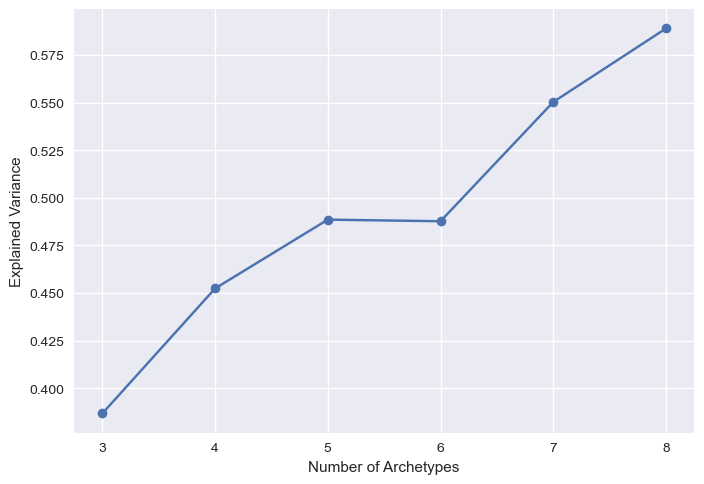

[[ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]
 [ 1.0000000e+00 -2.4492936e-16]]


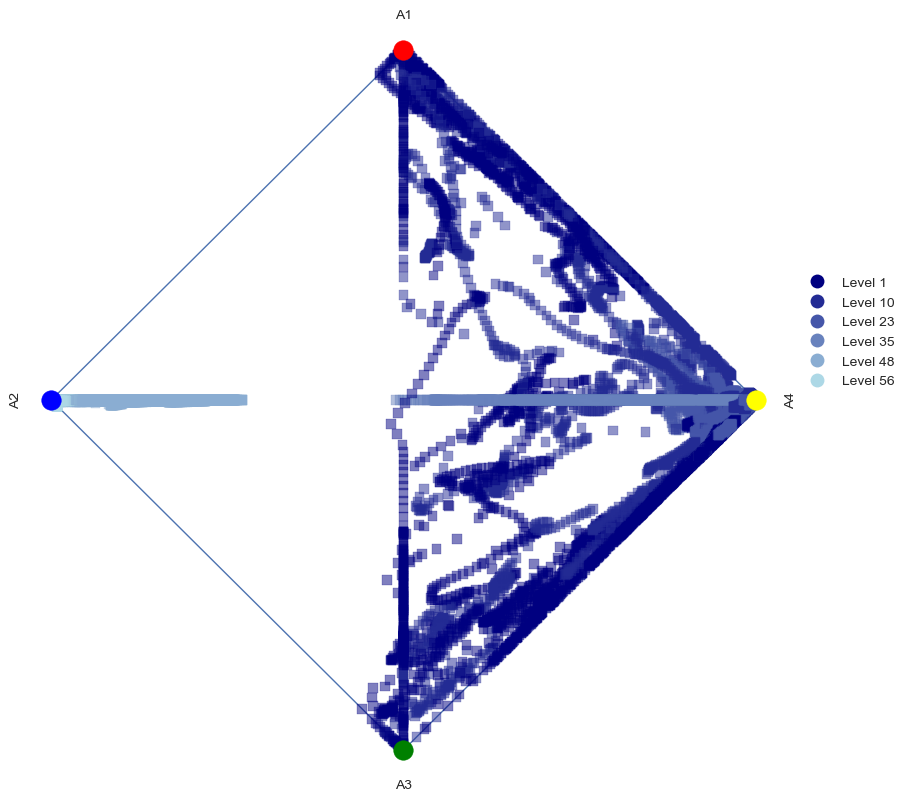

[[ 6.12323400e-17  1.00000000e+00]
 [-9.51056516e-01  3.09016994e-01]
 [-5.87785252e-01 -8.09016994e-01]
 [ 5.87785252e-01 -8.09016994e-01]
 [ 9.51056516e-01  3.09016994e-01]]


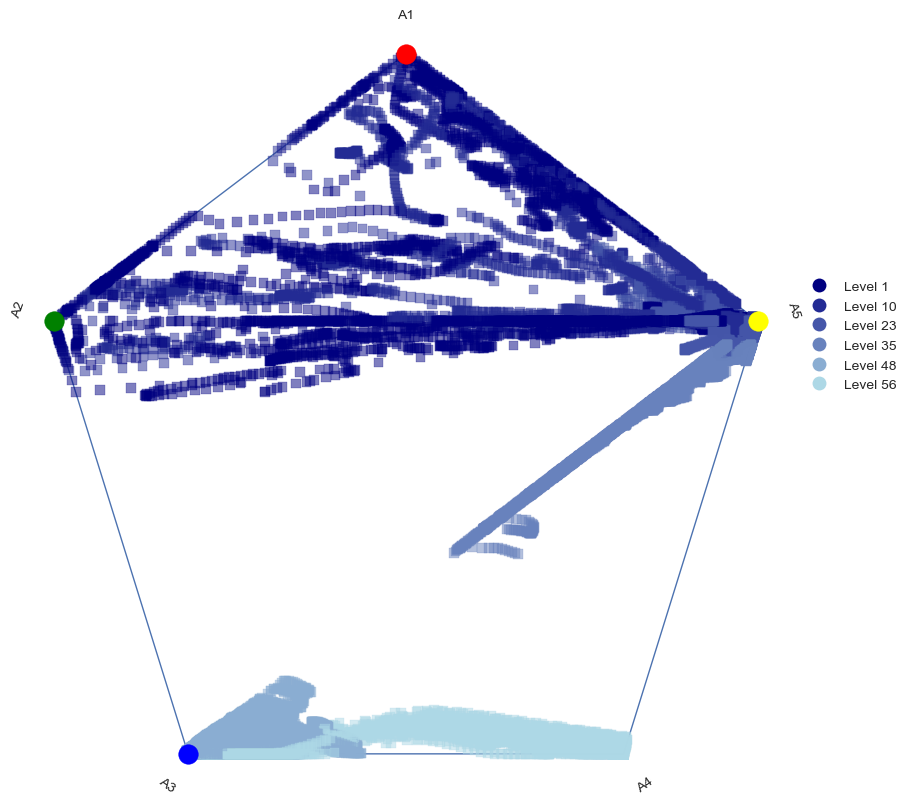

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01  5.00000000e-01]
 [-8.66025404e-01 -5.00000000e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01  5.00000000e-01]]


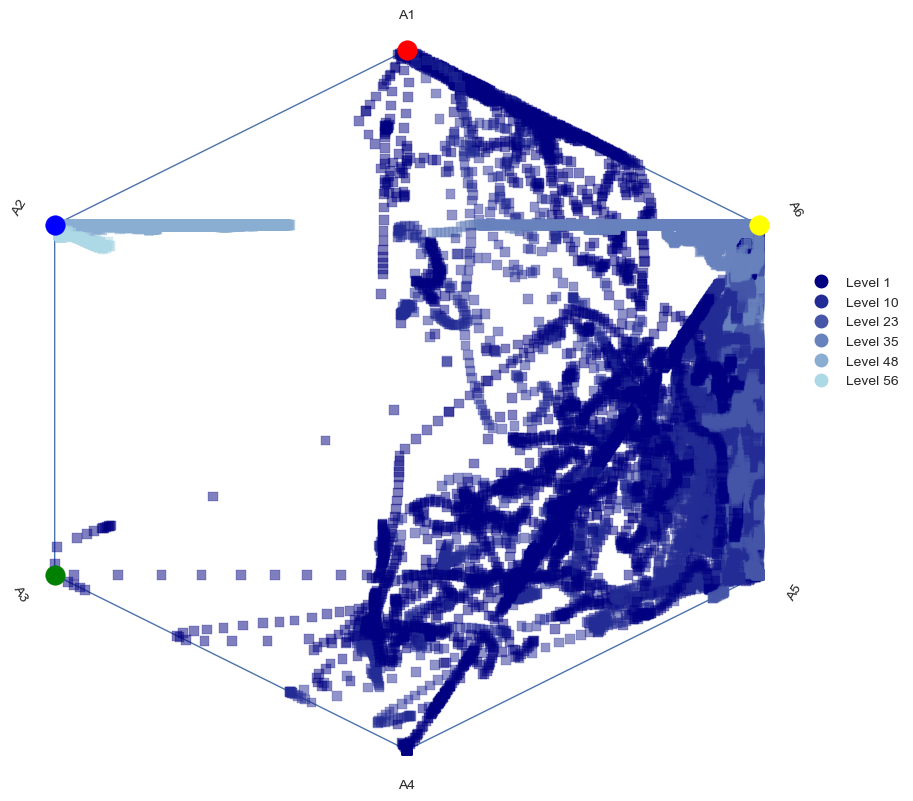

[[ 6.12323400e-17  1.00000000e+00]
 [-7.81831482e-01  6.23489802e-01]
 [-9.74927912e-01 -2.22520934e-01]
 [-4.33883739e-01 -9.00968868e-01]
 [ 4.33883739e-01 -9.00968868e-01]
 [ 9.74927912e-01 -2.22520934e-01]
 [ 7.81831482e-01  6.23489802e-01]]


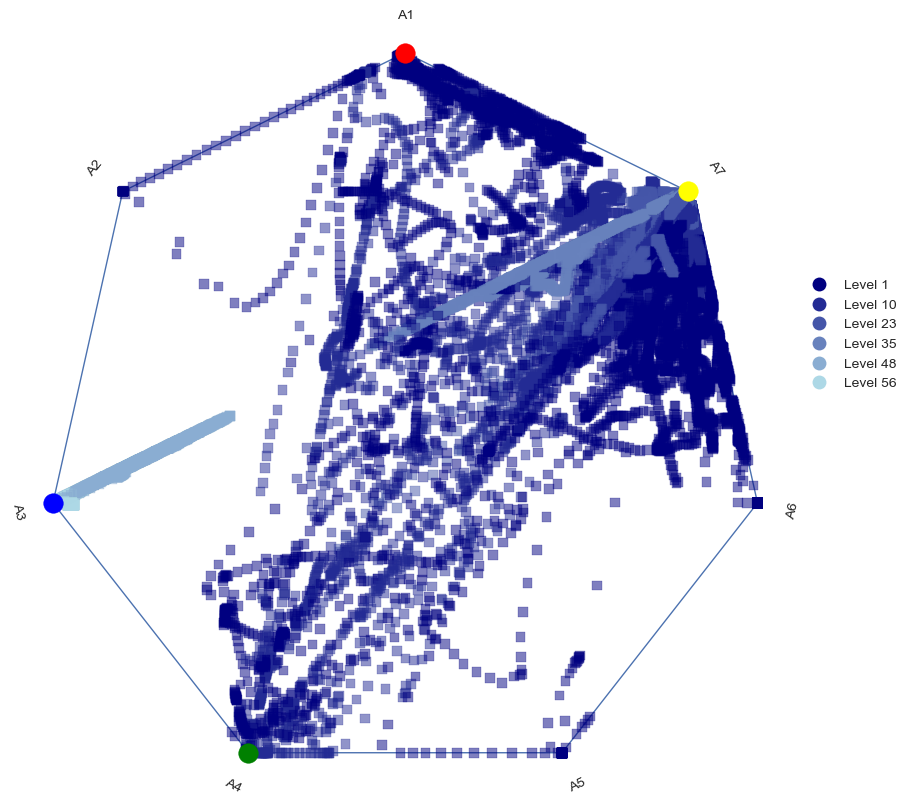

[[ 6.12323400e-17  1.00000000e+00]
 [-7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  1.22464680e-16]
 [-7.07106781e-01 -7.07106781e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01]
 [ 1.00000000e+00 -2.44929360e-16]
 [ 7.07106781e-01  7.07106781e-01]]


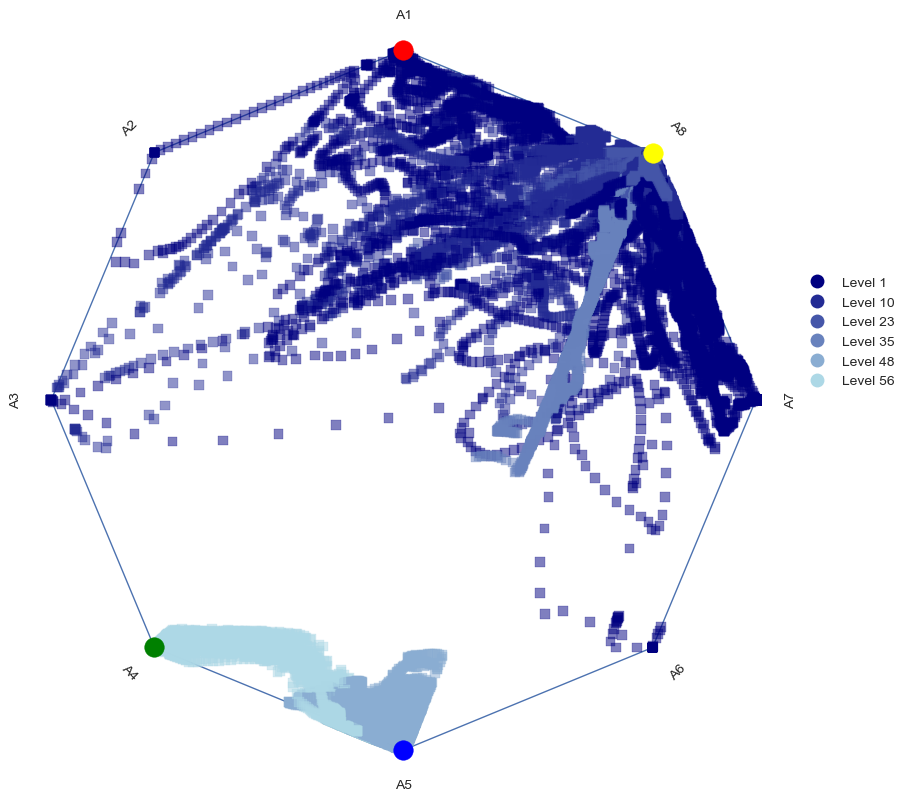

In [14]:
lst_feat = ['C' + str(i) for i in range(1,291+1)]

sc = StandardScaler()
X = concentration_df[lst_feat].values #Using concentration_df here
X_scaled = sc.fit_transform(X)

AA_list=[]
lst_exp_var = []
for i in range(3,9):
    AA = ArchetypalAnalysis(n_archetypes = i, 
                            tolerance = 0.001, 
                            max_iter = 200, 
                            random_state = 0, 
                            C = 0.0001, 
                            initialize = 'random',
                            redundancy_try = 30)
    AA.fit(X_scaled)
    AA_list.append(AA)
    lst_exp_var.append(AA.explained_variance_)
    
#explained variance
n_archs = list(range(3, 9))
plt.style.use('seaborn')
plt.plot(n_archs, lst_exp_var, '-o')
plt.xlabel('Number of Archetypes')
plt.ylabel('Explained Variance')
plt.show()
    
#coloring - Level
num_colors = 6
# Define the range of blue hues
start_color = np.array(mcolors.to_rgb('navy'))
end_color = np.array(mcolors.to_rgb('lightblue'))
# Generate a gradient of blue hues
colors = [mcolors.to_hex(start_color + (i / (num_colors - 1)) * (end_color - start_color)) for i in range(num_colors)]
# Create a dictionary mapping unique levels to colors
uniq_levels = sorted(df['level'].unique())
color_dict = {level: color for level, color in zip(uniq_levels, colors)}
# Map the dictionary to the 'level' column to assign colors
df_args = df[['level']].copy()
df_args['color'] = df_args['level'].map(color_dict)
plot_args = {'color': df_args['color']}
color_dict = {'Level '+str(level): color for level, color in zip(uniq_levels, colors)}

#simplex plots    
arr1 = AA_list[1].archetypes.T
color_indices = []
for AA in AA_list[1:]:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, legend_color = color_dict)

# Analysis on level - 1 concentrations

In [17]:
level1_df = df[df['level']==1]
level1_df

location         timestamp  longitude  \
filename                                                                      
AmazonTwilight_L1_20180101_2145.txt     Amazon  2018/01/01 21:45   -62.3631   
AmazonTwilight_L1_20180101_2200.txt     Amazon  2018/01/01 22:00   -62.3631   
AmazonTwilight_L1_20180101_2215.txt     Amazon  2018/01/01 22:15   -62.3631   
AmazonTwilight_L1_20180101_2230.txt     Amazon  2018/01/01 22:30   -62.3631   
AmazonTwilight_L1_20180102_0930.txt     Amazon  2018/01/02 09:30   -62.3631   
...                                        ...               ...        ...   
Utqiagvik_L1_20181001_1945.txt       Utqiagvik  2018/10/01 19:45  -156.9671   
Utqiagvik_L1_20181001_2000.txt       Utqiagvik  2018/10/01 20:00  -156.9671   
Utqiagvik_L1_20181001_2015.txt       Utqiagvik  2018/10/01 20:15  -156.9671   
Utqiagvik_L1_20181001_2030.txt       Utqiagvik  2018/10/01 20:30  -156.9671   
Utqiagvik_L1_20181001_2045.txt       Utqiagvik  2018/10/01 20:45  -156.9671   

                                     latitude  level  temperature   pressure  \
filename                                                                       
AmazonTwilight_L1_20180101_2145.txt    -3.071      1       300.72   993.7992   
AmazonTwilight_L1_20180101_2200.txt    -3.071      1       300.79   993.9504   
AmazonTwilight_L1_20180101_2215.txt    -3.071      1       300.76   993.8056   
AmazonTwilight_L1_20180101_2230.txt    -3.071      1       300.69   993.9412   
AmazonTwilight_L1_20180102_0930.txt    -3.071      1       296.97   995.7482   
...                                       ...    ...          ...        ...   
Utqiagvik_L1_20181001_1945.txt         71.274      1       274.11  1010.8470   
Utqiagvik_L1_20181001_2000.txt         71.274      1       274.23  1010.7416   
Utqiagvik_L1_20181001_2015.txt         71.274      1       274.35  1010.6275   
Utqiagvik_L1_20181001_2030.txt         71.274      1       274.48  1010.5036   
Utqiagvik_L1_20181001_2045.txt         71.274      1       274.62  1010.3681   

                                     air_number_density  average_water  \
filename                                                                 
AmazonTwilight_L1_20180101_2145.txt        2.351000e+19       0.034260   
AmazonTwilight_L1_20180101_2200.txt        2.353000e+19       0.032070   
AmazonTwilight_L1_20180101_2215.txt        2.353000e+19       0.031900   
AmazonTwilight_L1_20180101_2230.txt        2.354000e+19       0.031920   
AmazonTwilight_L1_20180102_0930.txt        2.389000e+19       0.030710   
...                                                 ...            ...   
Utqiagvik_L1_20181001_1945.txt             2.664000e+19       0.005853   
Utqiagvik_L1_20181001_2000.txt             2.662000e+19       0.005867   
Utqiagvik_L1_20181001_2015.txt             2.661000e+19       0.005885   
Utqiagvik_L1_20181001_2030.txt             2.659000e+19       0.005909   
Utqiagvik_L1_20181001_2045.txt             2.657000e+19       0.005936   

                                     cloud_fraction  ...          K906  \
filename                                             ...                 
AmazonTwilight_L1_20180101_2145.txt          0.0000  ...  6.739687e-08   
AmazonTwilight_L1_20180101_2200.txt          0.0000  ...  2.341813e-08   
AmazonTwilight_L1_20180101_2215.txt          0.0000  ...  3.581853e-09   
AmazonTwilight_L1_20180101_2230.txt          0.0000  ...  1.196162e-10   
AmazonTwilight_L1_20180102_0930.txt          0.8907  ...  3.019319e-11   
...                                             ...  ...           ...   
Utqiagvik_L1_20181001_1945.txt               0.0000  ...  2.594007e-07   
Utqiagvik_L1_20181001_2000.txt               0.0000  ...  2.873300e-07   
Utqiagvik_L1_20181001_2015.txt               0.0000  ...  3.139810e-07   
Utqiagvik_L1_20181001_2030.txt               0.0000  ...  3.390501e-07   
Utqiagvik_L1_20181001_2045.txt               0.0000  ...  3.620955e-07   

                                           

## Color by location

C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\964556730.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


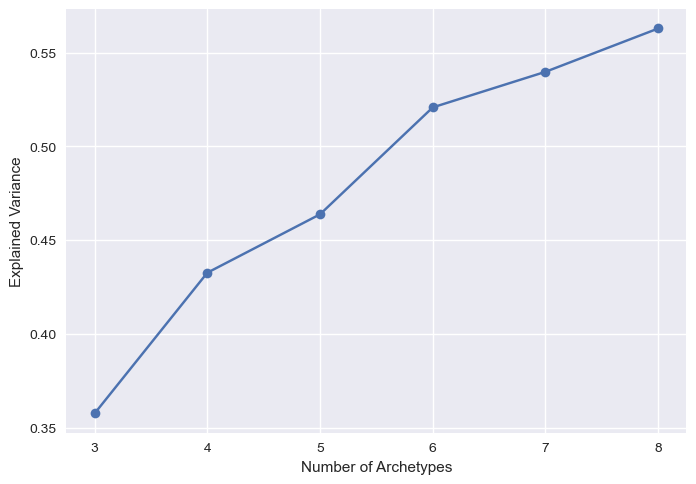

[[ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]
 [ 1.0000000e+00 -2.4492936e-16]]


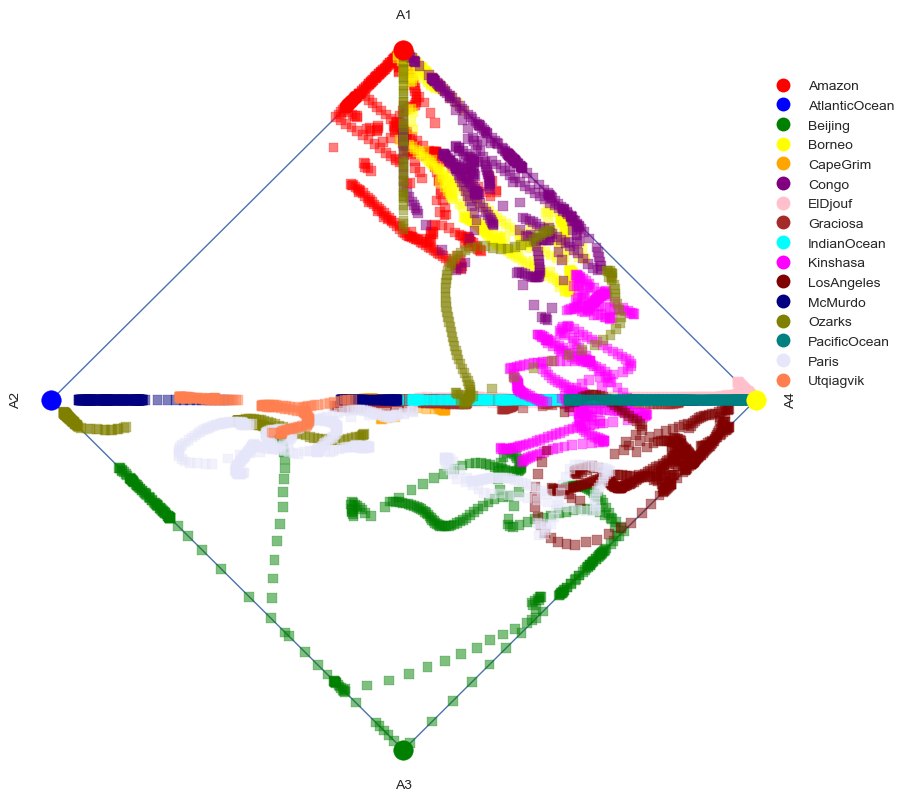

[[ 6.12323400e-17  1.00000000e+00]
 [-9.51056516e-01  3.09016994e-01]
 [-5.87785252e-01 -8.09016994e-01]
 [ 5.87785252e-01 -8.09016994e-01]
 [ 9.51056516e-01  3.09016994e-01]]


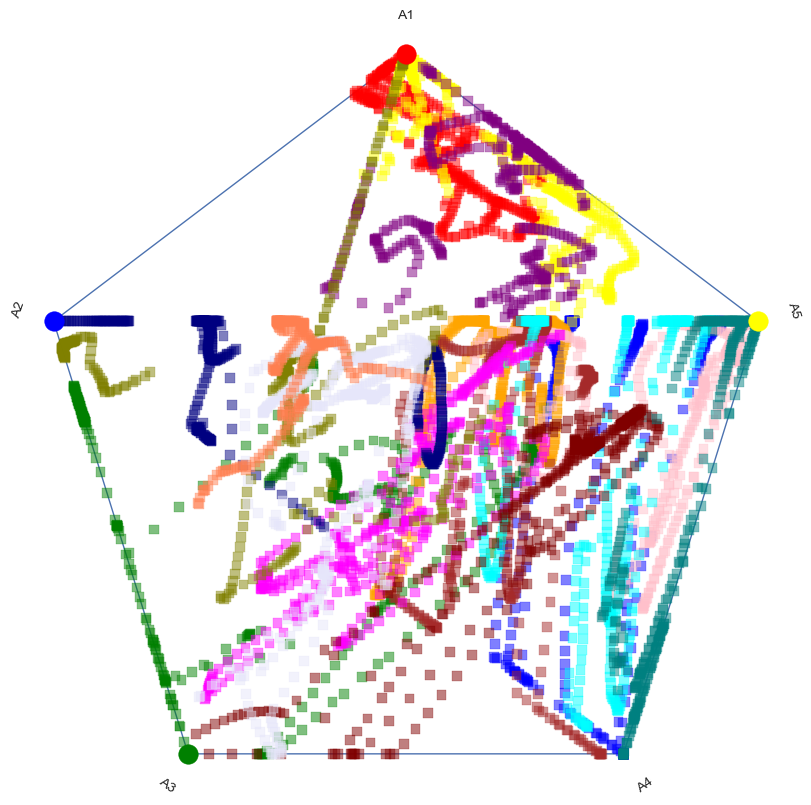

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01  5.00000000e-01]
 [-8.66025404e-01 -5.00000000e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01  5.00000000e-01]]


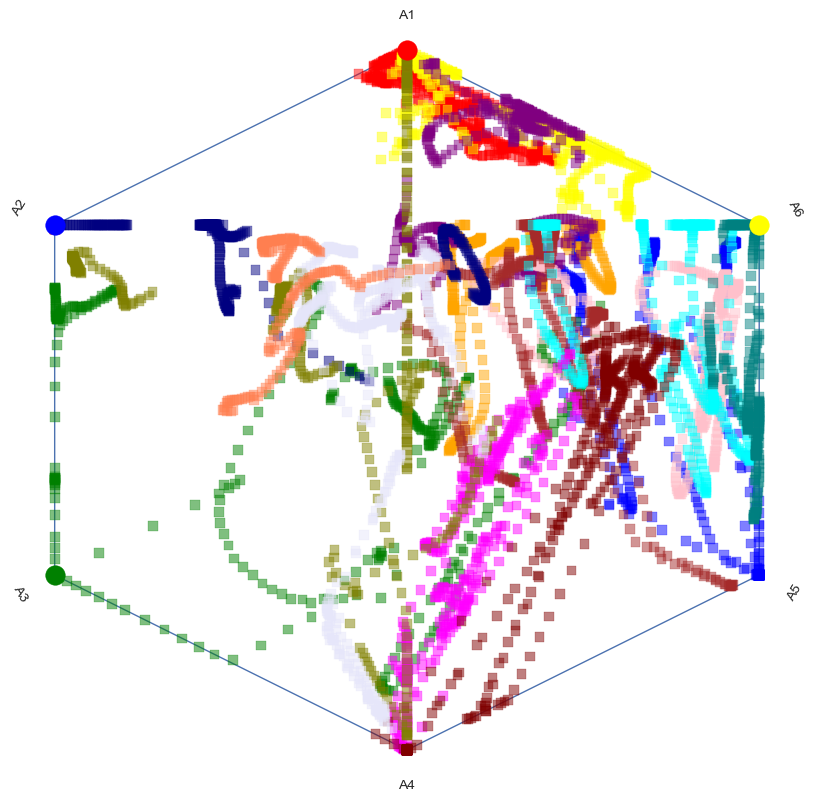

[[ 6.12323400e-17  1.00000000e+00]
 [-7.81831482e-01  6.23489802e-01]
 [-9.74927912e-01 -2.22520934e-01]
 [-4.33883739e-01 -9.00968868e-01]
 [ 4.33883739e-01 -9.00968868e-01]
 [ 9.74927912e-01 -2.22520934e-01]
 [ 7.81831482e-01  6.23489802e-01]]


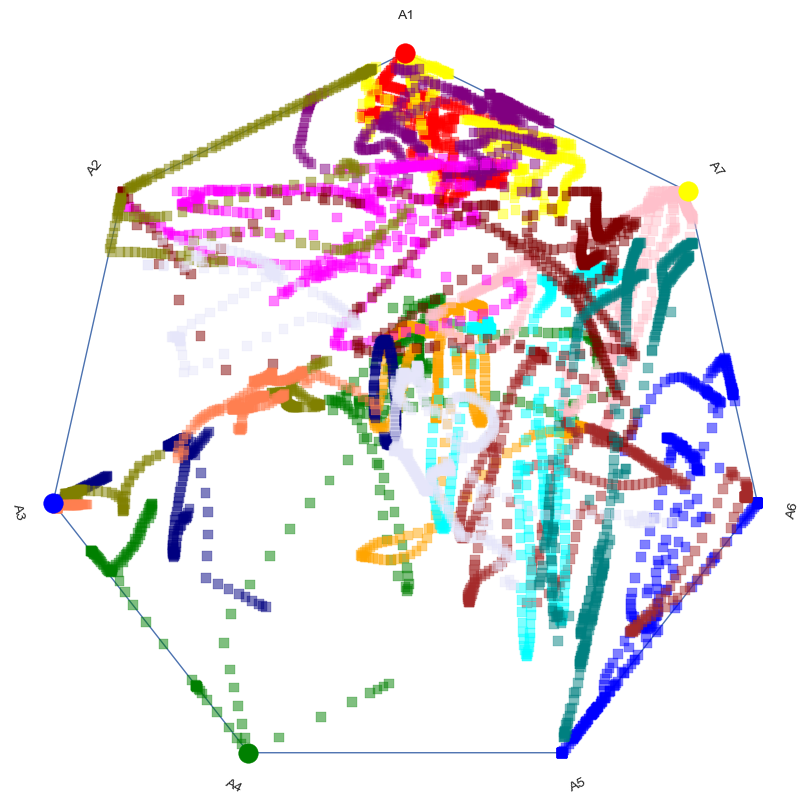

[[ 6.12323400e-17  1.00000000e+00]
 [-7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  1.22464680e-16]
 [-7.07106781e-01 -7.07106781e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01]
 [ 1.00000000e+00 -2.44929360e-16]
 [ 7.07106781e-01  7.07106781e-01]]


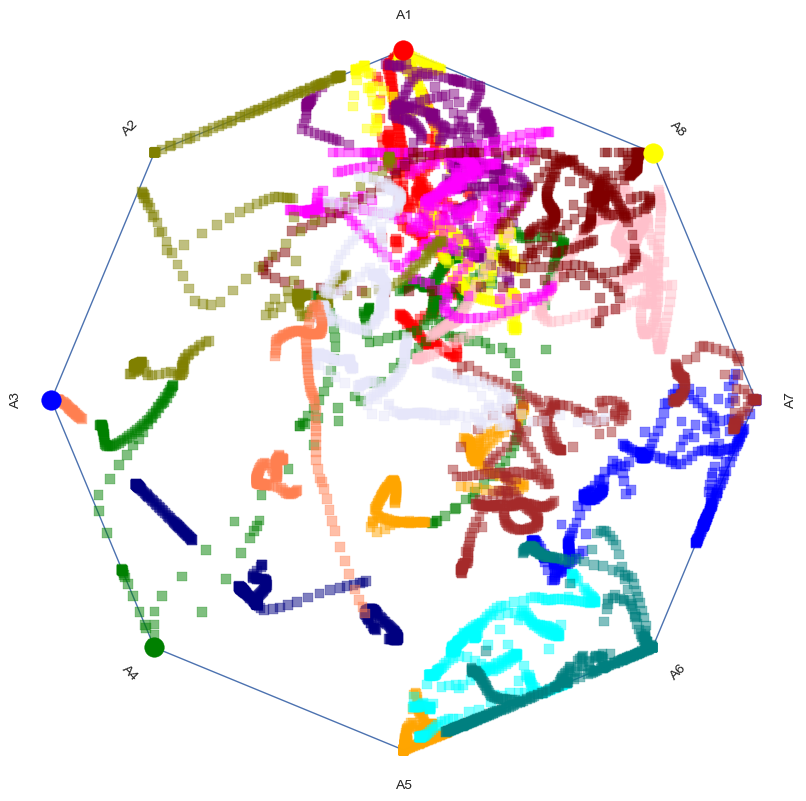

In [18]:
lst_feat = ['C' + str(i) for i in range(1,291+1)]

sc = StandardScaler()
X = level1_df[lst_feat].values #Using level1_df here
X_scaled = sc.fit_transform(X)

AA_list_level1=[]
lst_exp_var_level1 = []
for i in range(3,9):
    AA = ArchetypalAnalysis(n_archetypes = i, 
                            tolerance = 0.001, 
                            max_iter = 200, 
                            random_state = 0, 
                            C = 0.0001, 
                            initialize = 'random',
                            redundancy_try = 30)
    AA.fit(X_scaled)
    AA_list_level1.append(AA)
    lst_exp_var_level1.append(AA.explained_variance_)
    
#explained variance
n_archs = list(range(3, 9))
plt.style.use('seaborn')
plt.plot(n_archs, lst_exp_var_level1, '-o')
plt.xlabel('Number of Archetypes')
plt.ylabel('Explained Variance')
plt.show()

#coloring - Location
colors = ['Red', 'Blue', 'Green', 'Yellow', 'Orange', 'Purple', 'Pink', 'Brown', 'Cyan', 'Magenta', 'Maroon', 'Navy', 'Olive', 'Teal', 'Lavender', 'Coral']
df_args = level1_df[['location']].copy()
df_args['color'] = colors[0]
uniq_locations = df_args['location'].unique()
color_dict = {location: color for location, color in zip(uniq_locations, colors)}
df_args['color'] = df_args['location'].map(color_dict)
plot_args = {'color': df_args['color']}
color_dict = {location: color for location, color in zip(uniq_locations, colors)}

#simplex plots    
flag = True
arr1 = AA_list_level1[1].archetypes.T
color_indices = []
for AA in AA_list_level1[1:]:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    if flag:
        flag = False
        plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, legend_color = color_dict, label = True)
    else:
        plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, legend_color = color_dict, label = False)

## Color by Region

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01 -5.00000000e-01]]


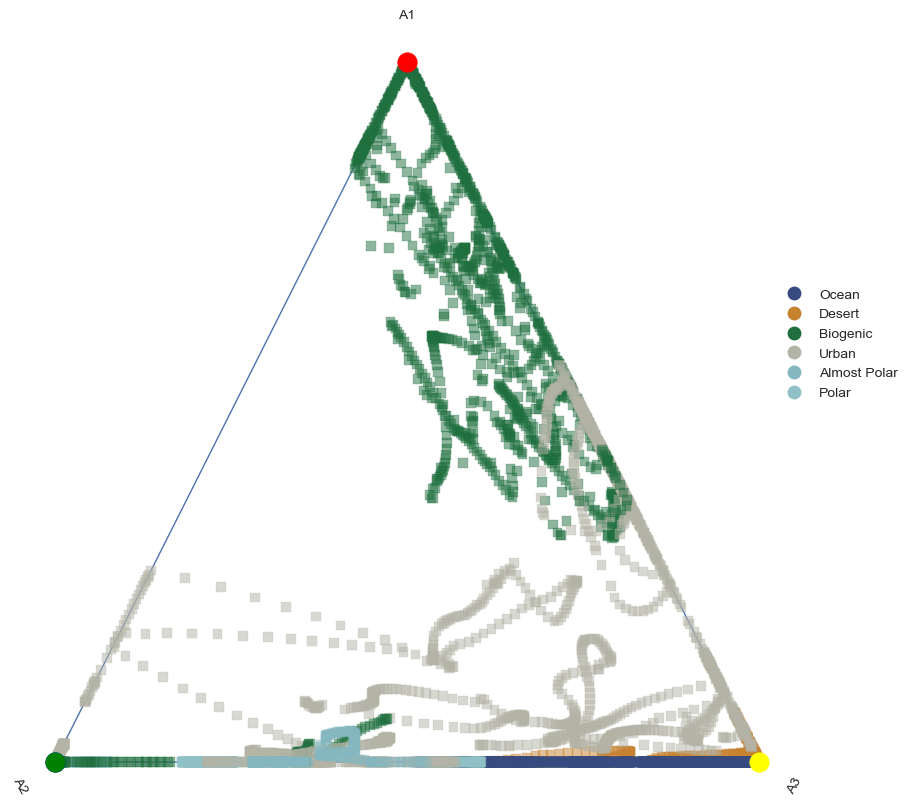

[[ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]
 [ 1.0000000e+00 -2.4492936e-16]]


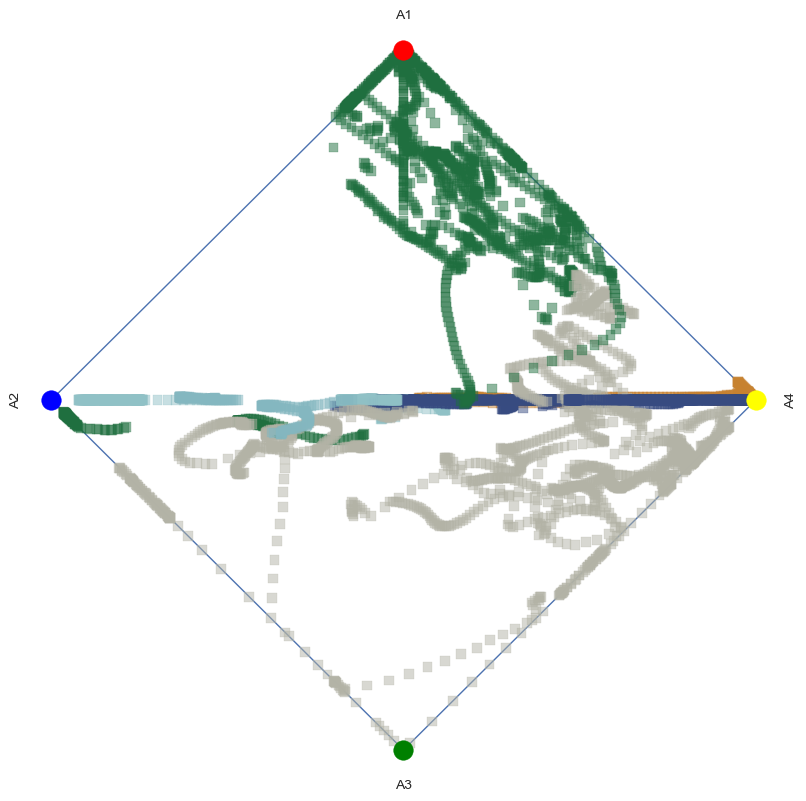

[[ 6.12323400e-17  1.00000000e+00]
 [-9.51056516e-01  3.09016994e-01]
 [-5.87785252e-01 -8.09016994e-01]
 [ 5.87785252e-01 -8.09016994e-01]
 [ 9.51056516e-01  3.09016994e-01]]


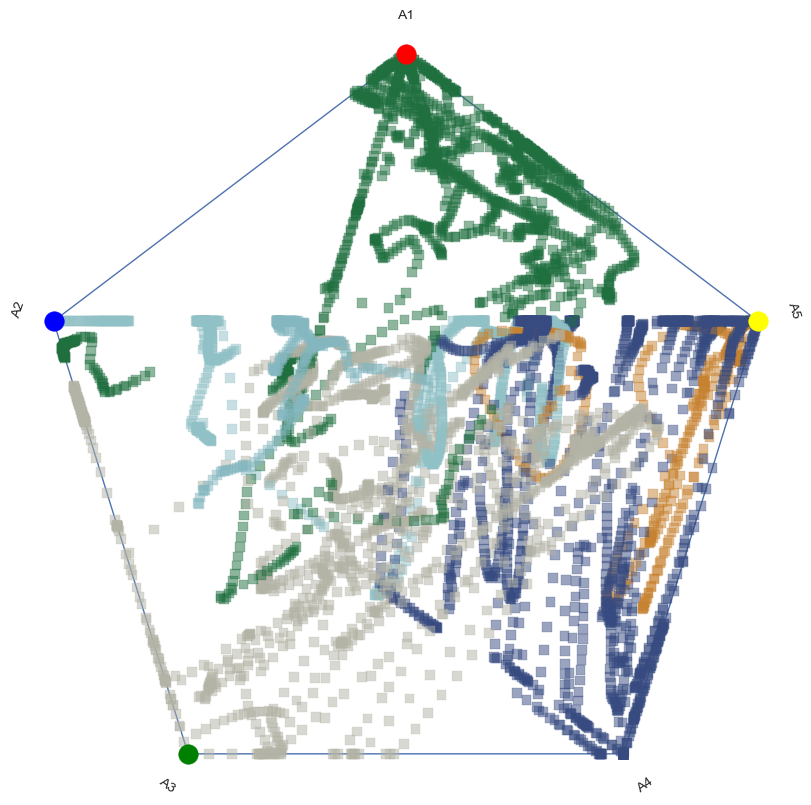

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01  5.00000000e-01]
 [-8.66025404e-01 -5.00000000e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01  5.00000000e-01]]


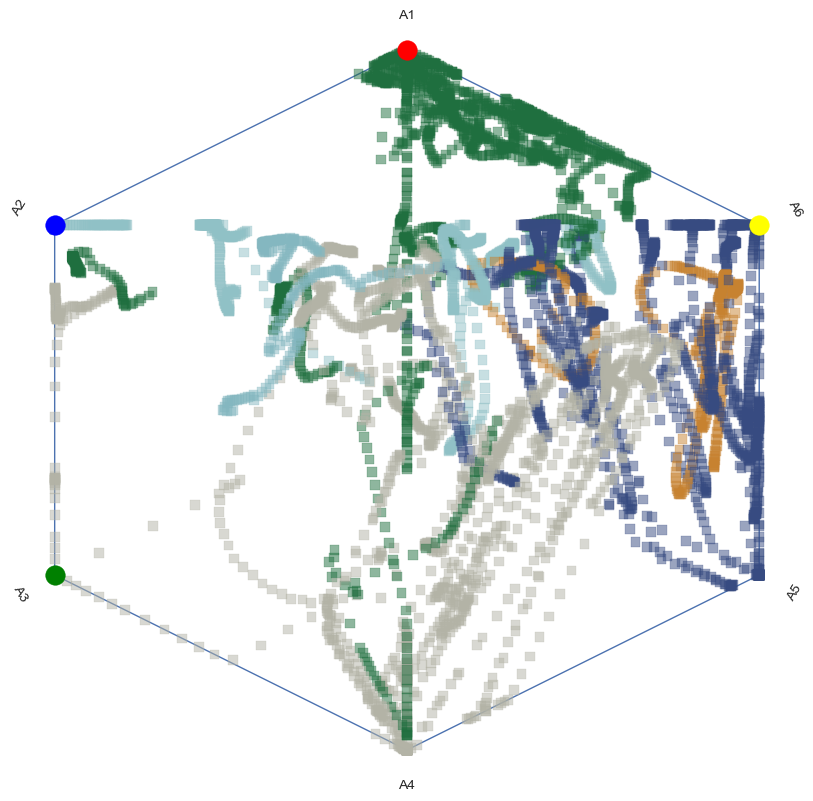

[[ 6.12323400e-17  1.00000000e+00]
 [-7.81831482e-01  6.23489802e-01]
 [-9.74927912e-01 -2.22520934e-01]
 [-4.33883739e-01 -9.00968868e-01]
 [ 4.33883739e-01 -9.00968868e-01]
 [ 9.74927912e-01 -2.22520934e-01]
 [ 7.81831482e-01  6.23489802e-01]]


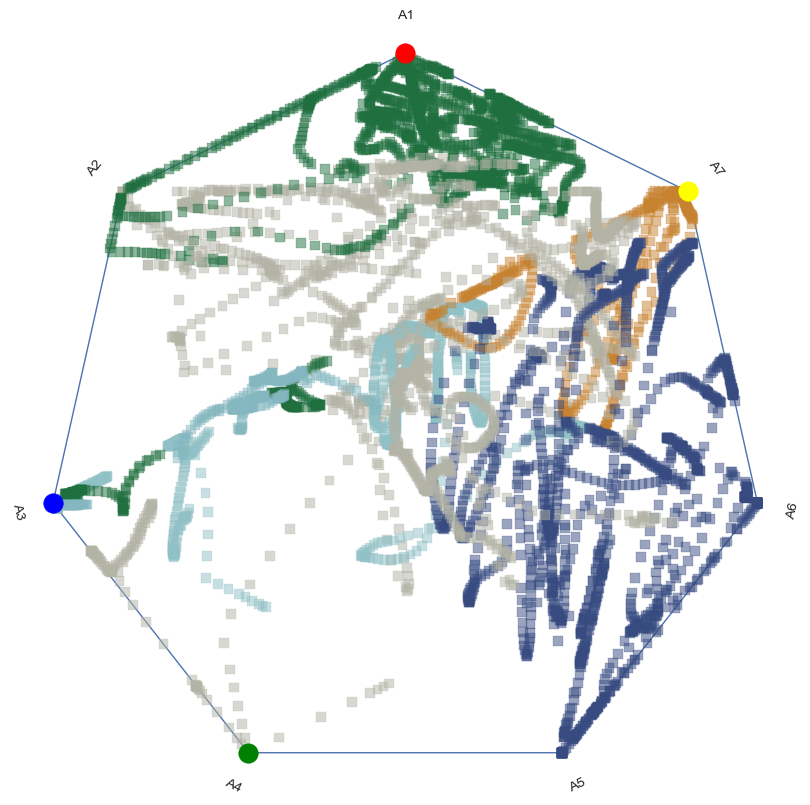

[[ 6.12323400e-17  1.00000000e+00]
 [-7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  1.22464680e-16]
 [-7.07106781e-01 -7.07106781e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01]
 [ 1.00000000e+00 -2.44929360e-16]
 [ 7.07106781e-01  7.07106781e-01]]


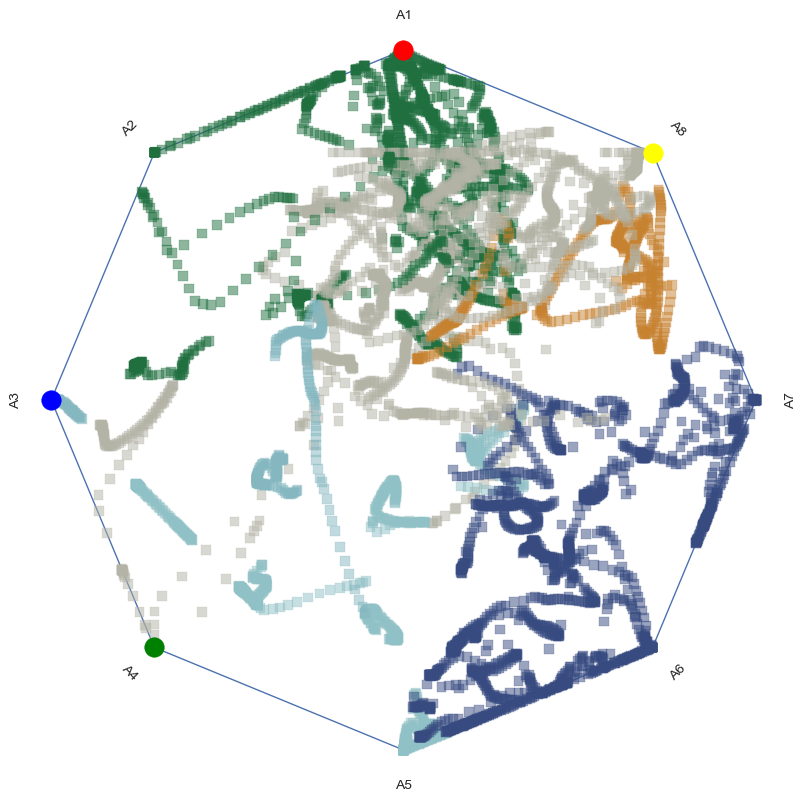

In [19]:
#coloring - Region
df_args = level1_df[['region']].copy()
df_args['color'] = df_args['region'].map(region_color)
plot_args = {'color': df_args['color']}
color_dict = region_color

#simplex plots    
flag = True
arr1 = AA_list_level1[1].archetypes.T
color_indices = []
for AA in AA_list_level1:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    if flag:
        flag = False
        plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, legend_color = color_dict, label = True)
    else:
        plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, legend_color = color_dict, label = False)

[[ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]
 [ 1.0000000e+00 -2.4492936e-16]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


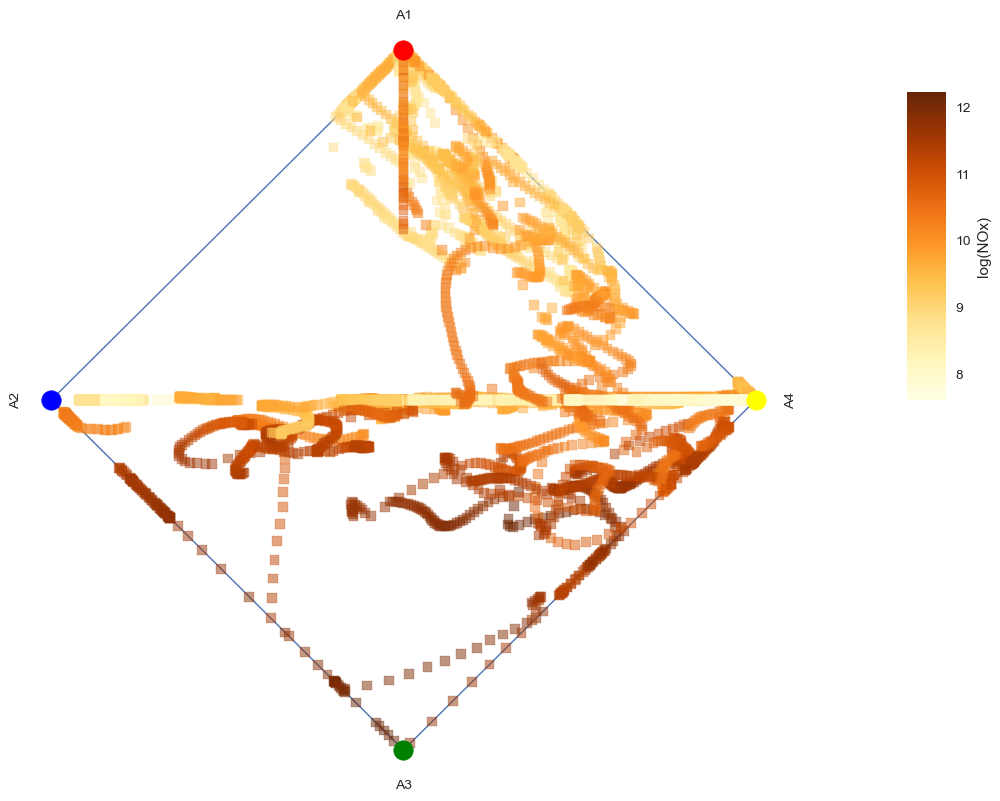

[[ 6.12323400e-17  1.00000000e+00]
 [-9.51056516e-01  3.09016994e-01]
 [-5.87785252e-01 -8.09016994e-01]
 [ 5.87785252e-01 -8.09016994e-01]
 [ 9.51056516e-01  3.09016994e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


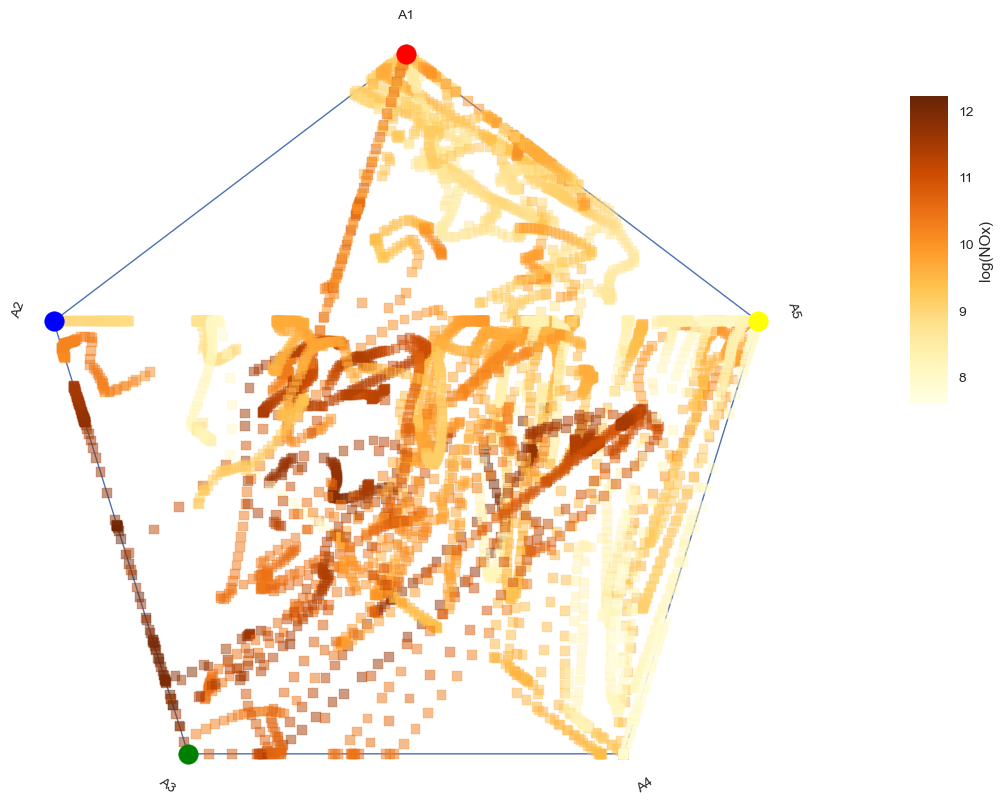

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01  5.00000000e-01]
 [-8.66025404e-01 -5.00000000e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01  5.00000000e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


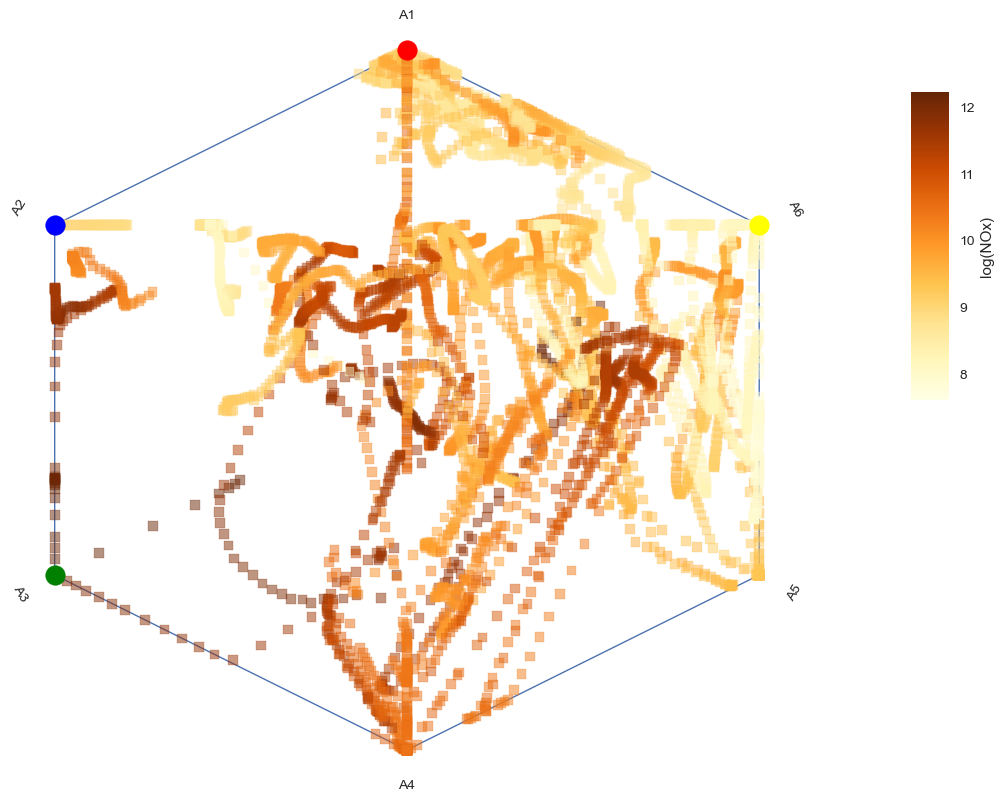

[[ 6.12323400e-17  1.00000000e+00]
 [-7.81831482e-01  6.23489802e-01]
 [-9.74927912e-01 -2.22520934e-01]
 [-4.33883739e-01 -9.00968868e-01]
 [ 4.33883739e-01 -9.00968868e-01]
 [ 9.74927912e-01 -2.22520934e-01]
 [ 7.81831482e-01  6.23489802e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


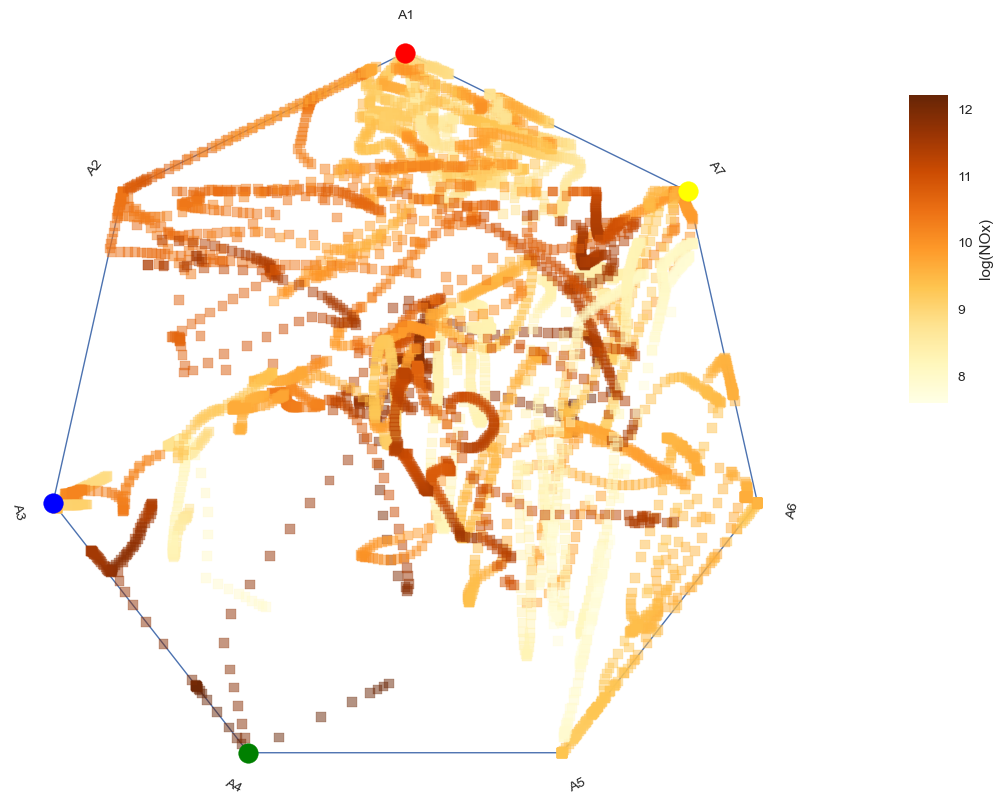

[[ 6.12323400e-17  1.00000000e+00]
 [-7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  1.22464680e-16]
 [-7.07106781e-01 -7.07106781e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01]
 [ 1.00000000e+00 -2.44929360e-16]
 [ 7.07106781e-01  7.07106781e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


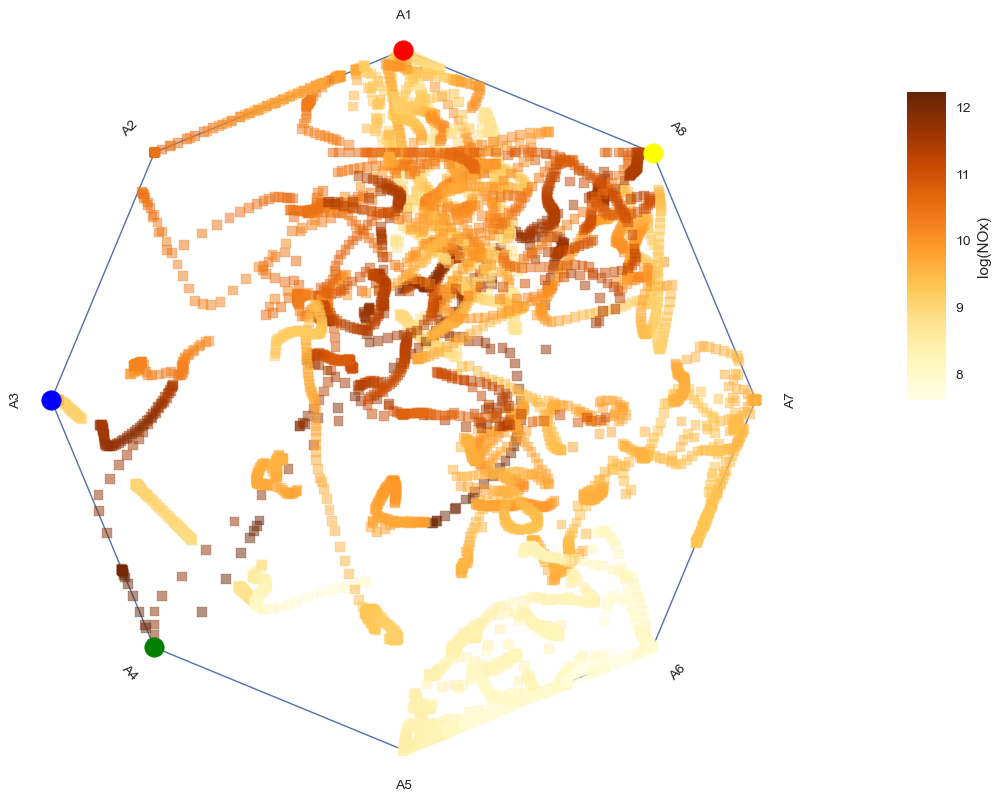

In [22]:
#coloring - NOX

legend_color = list(level1_df['C270'] + level1_df['C280']) #get concentrations
legend_color = np.log10(np.array(legend_color))
plot_args = {'color':None}

#simplex plots    
flag = True
arr1 = AA_list_level1[1].archetypes.T
color_indices = []
for AA in AA_list_level1[1:]:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    if flag:
        flag = False
        plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, cmap='YlOrBr', categorical=False, legend_color = legend_color, label = 'log(NOx)')
    else:
        plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, cmap='YlOrBr', categorical=False, legend_color = legend_color, label = 'log(NOx)')

## Feature space exploration

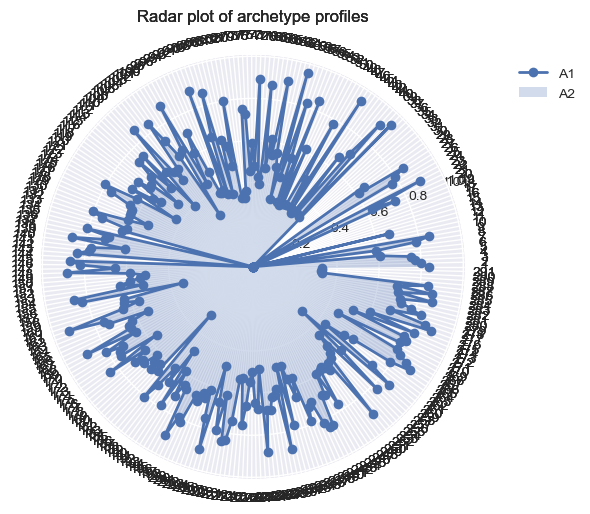

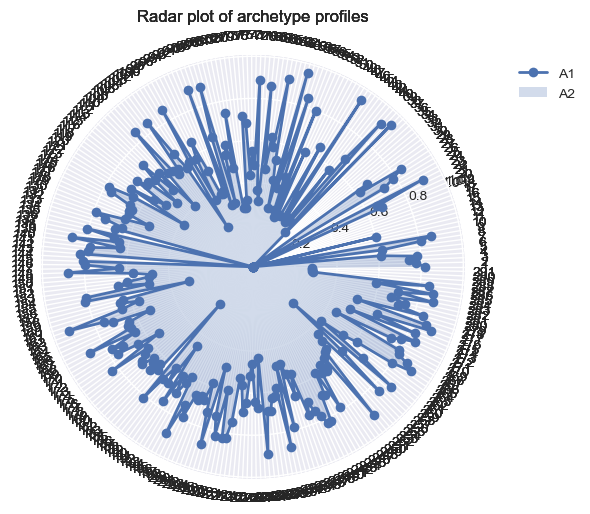

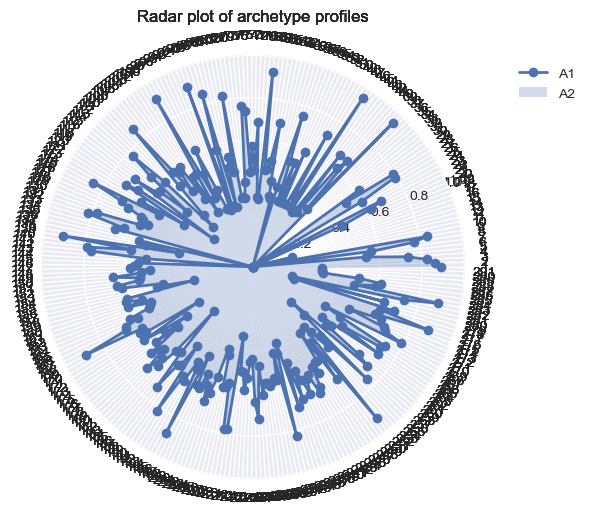

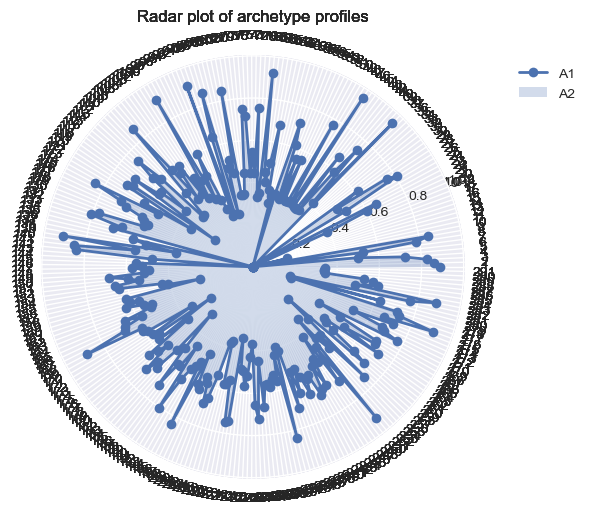

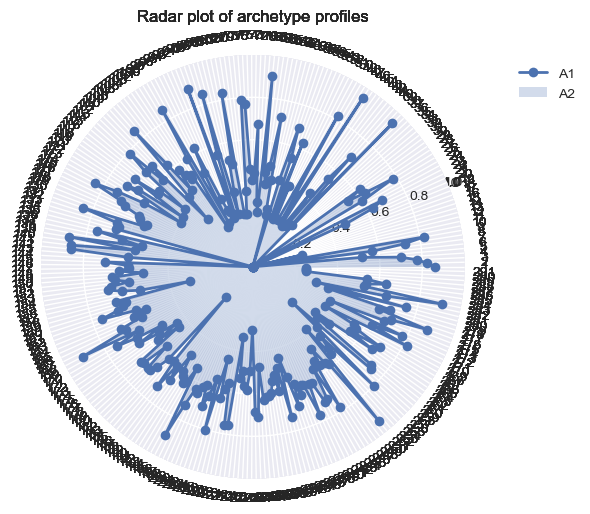

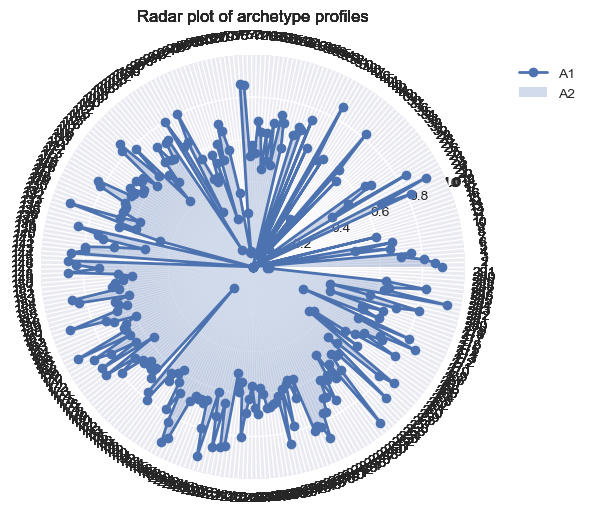

In [20]:
for AA in AA_list_level1:
    AA.plot_radar_profile(feature_cols = None, Title = 'Radar plot of archetype profiles')

In [21]:
# the fucntion provided in the library is not working properly, plotting only 2 archetypes
# will need to debug this function for better plot (also need to turn off the chemical number label)

# Analysis on April level - 1 LA rates

In [23]:
L1_rates = df[df['level'] == 1].copy()
L1_LA_rates = L1_rates[L1_rates['location'] == 'LosAngeles'].copy()
L1_LA_rates['timestamp'] = pd.to_datetime(L1_LA_rates['timestamp'], format='%Y/%m/%d %H:%M')
L1_LA_rates['month'] = L1_LA_rates['timestamp'].dt.month
April_L1_LA_rates_df = L1_LA_rates[L1_LA_rates['month'] == 4].copy()
April_L1_LA_rates_df

location           timestamp  \
filename                                                                  
LosAngelesTwilight_L1_20180402_0130.txt  LosAngeles 2018-04-02 01:30:00   
LosAngelesTwilight_L1_20180402_0145.txt  LosAngeles 2018-04-02 01:45:00   
LosAngelesTwilight_L1_20180402_0200.txt  LosAngeles 2018-04-02 02:00:00   
LosAngelesTwilight_L1_20180402_0215.txt  LosAngeles 2018-04-02 02:15:00   
LosAngelesTwilight_L1_20180402_0230.txt  LosAngeles 2018-04-02 02:30:00   
...                                             ...                 ...   
LosAngeles_L1_20180402_1945.txt          LosAngeles 2018-04-02 19:45:00   
LosAngeles_L1_20180402_2000.txt          LosAngeles 2018-04-02 20:00:00   
LosAngeles_L1_20180402_2015.txt          LosAngeles 2018-04-02 20:15:00   
LosAngeles_L1_20180402_2030.txt          LosAngeles 2018-04-02 20:30:00   
LosAngeles_L1_20180402_2045.txt          LosAngeles 2018-04-02 20:45:00   

                                         longitude  latitude  level  \
filename                                                              
LosAngelesTwilight_L1_20180402_0130.txt  -117.9876   34.4658      1   
LosAngelesTwilight_L1_20180402_0145.txt  -117.9876   34.4658      1   
LosAngelesTwilight_L1_20180402_0200.txt  -117.9876   34.4658      1   
LosAngelesTwilight_L1_20180402_0215.txt  -117.9876   34.4658      1   
LosAngelesTwilight_L1_20180402_0230.txt  -117.9876   34.4658      1   
...                                            ...       ...    ...   
LosAngeles_L1_20180402_1945.txt          -117.9876   34.4658      1   
LosAngeles_L1_20180402_2000.txt          -117.9876   34.4658      1   
LosAngeles_L1_20180402_2015.txt          -117.9876   34.4658      1   
LosAngeles_L1_20180402_2030.txt          -117.9876   34.4658      1   
LosAngeles_L1_20180402_2045.txt          -117.9876   34.4658      1   

                                         temperature  pressure  \
filename                                                         
LosAngelesTwilight_L1_20180402_0130.txt       296.69  911.2661   
LosAngelesTwilight_L1_20180402_0145.txt       296.20  911.3063   
LosAngelesTwilight_L1_20180402_0200.txt       295.56  911.3462   
LosAngelesTwilight_L1_20180402_0215.txt       294.94  911.3923   
LosAngelesTwilight_L1_20180402_0230.txt       294.31  911.4551   
...                                              ...       ...   
LosAngeles_L1_20180402_1945.txt               294.76  910.6889   
LosAngeles_L1_20180402_2000.txt               295.12  910.5688   
LosAngeles_L1_20180402_2015.txt               295.45  910.4555   
LosAngeles_L1_20180402_2030.txt               295.75  910.3490   
LosAngeles_L1_20180402_2045.txt               296.03  910.2340   

                                         air_number_density  average_water  \
filename                                                                     
LosAngelesTwilight_L1_20180402_0130.txt        2.217000e+19       0.006205   
LosAngelesTwilight_L1_20180402_0145.txt        2.221000e+19       0.006339   
LosAngelesTwilight_L1_20180402_0200.txt        2.226000e+19       0.006500   
LosAngelesTwilight_L1_20180402_0215.txt        2.230000e+19       0.006657   
LosAngelesTwilight_L1_20180402_0230.txt        2.235000e+19       0.006815   
...                                                     ...            ...   
LosAngeles_L1_20180402_1945.txt                2.231000e+19       0.006184   
LosAngeles_L1_20180402_2000.txt                2.228000e+19       0.006169   
LosAngeles_L1_20180402_2015.txt                2.225000e+19       0.006184   
LosAngeles_L1_20180402_2030.txt                2.223000e+19       0.006176   
LosAngeles_L1_20180402_2045.txt                2.220000e+19       0.006201   

                                         cloud_fraction  ...          K907  \
filename                                                 ...                 
LosAngelesTwilight_L1_20180402_0130.txt             0.0  ...  3.258781e-06   
LosAngelesTwilight_L1_20180402_0145

## Coloring by cosine zenith

C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\2047159175.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


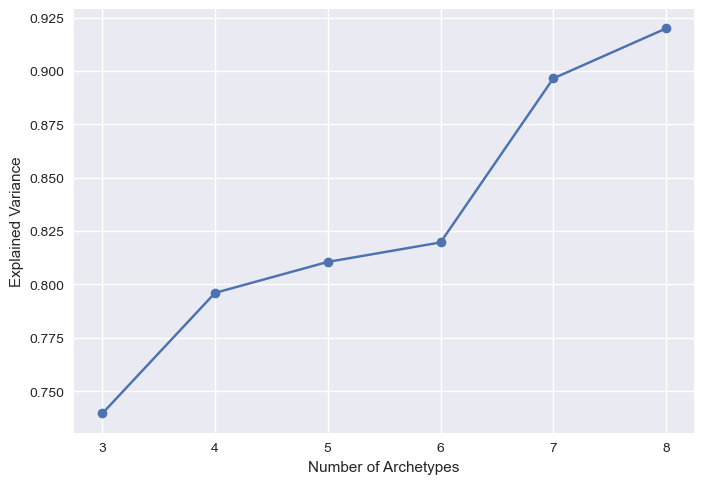

C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01 -5.00000000e-01]]


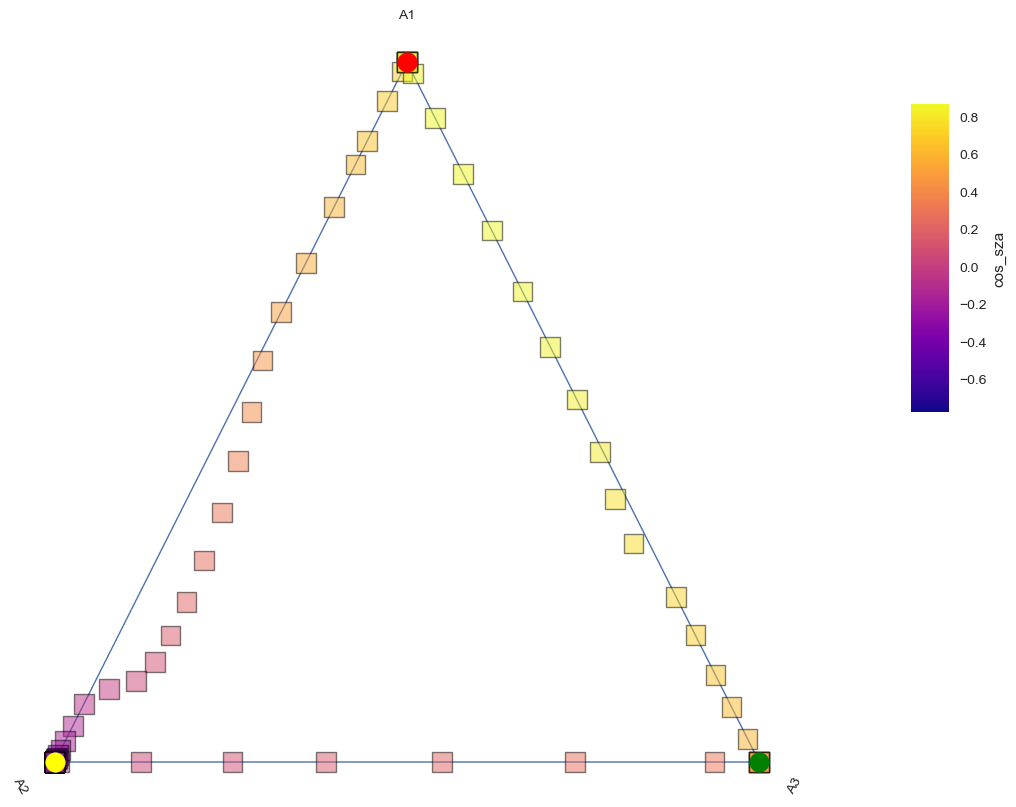

[[ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]
 [ 1.0000000e+00 -2.4492936e-16]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


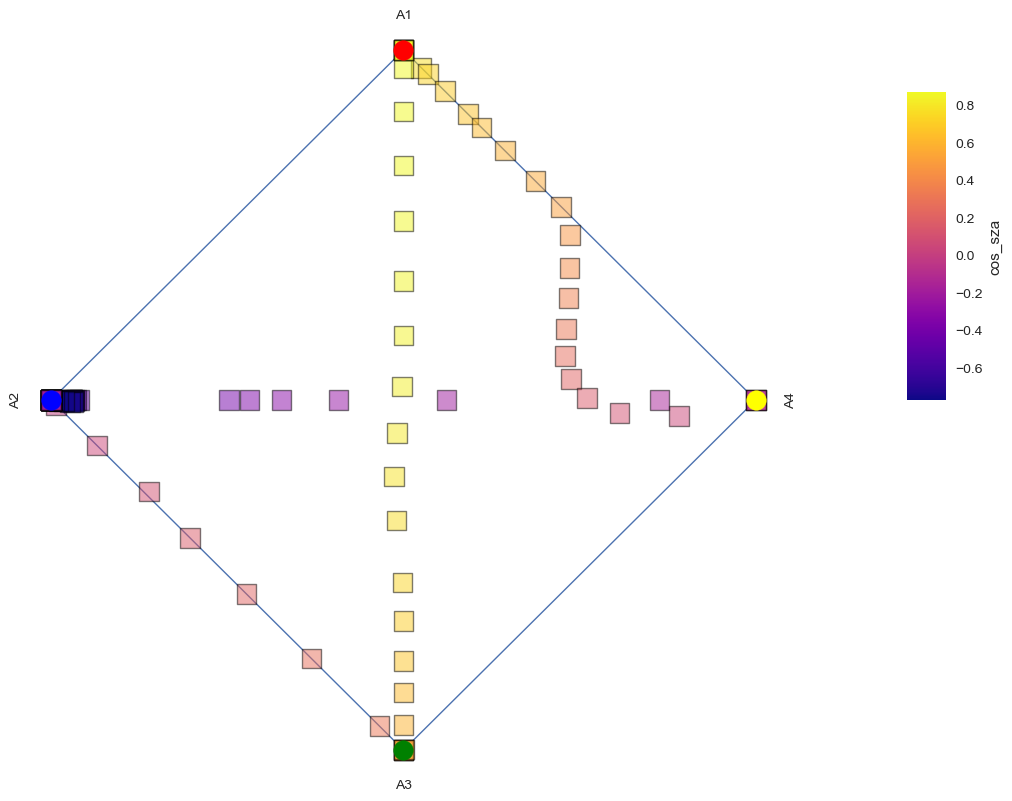

[[ 6.12323400e-17  1.00000000e+00]
 [-9.51056516e-01  3.09016994e-01]
 [-5.87785252e-01 -8.09016994e-01]
 [ 5.87785252e-01 -8.09016994e-01]
 [ 9.51056516e-01  3.09016994e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


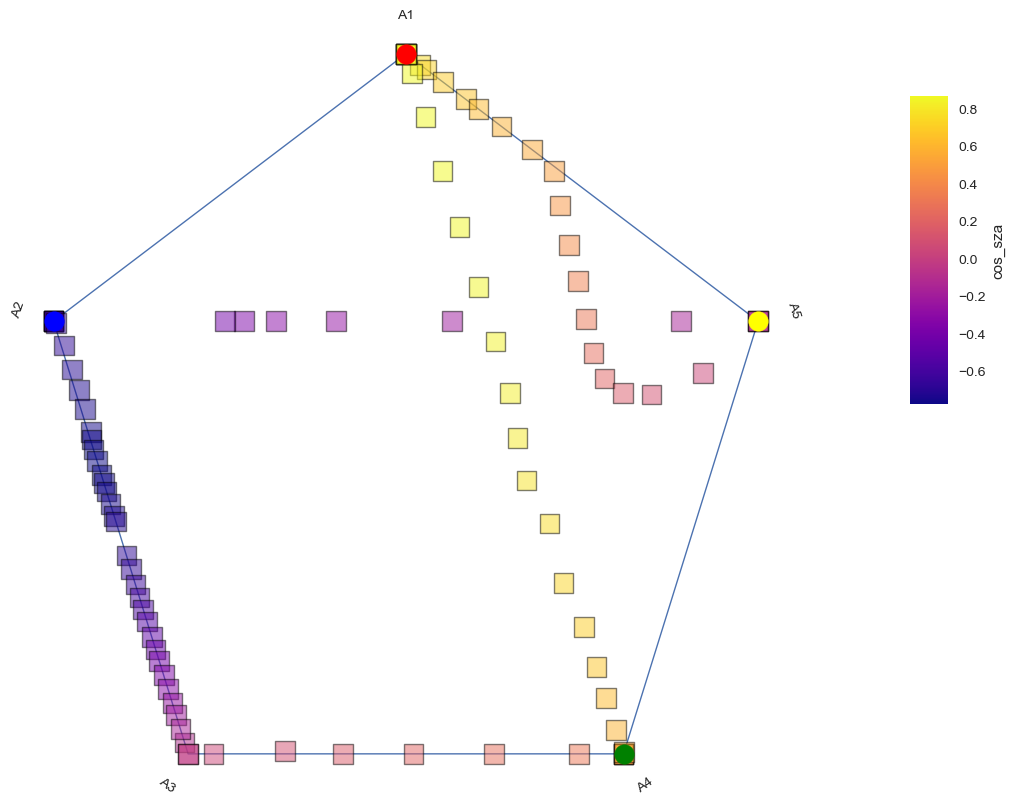

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01  5.00000000e-01]
 [-8.66025404e-01 -5.00000000e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01  5.00000000e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


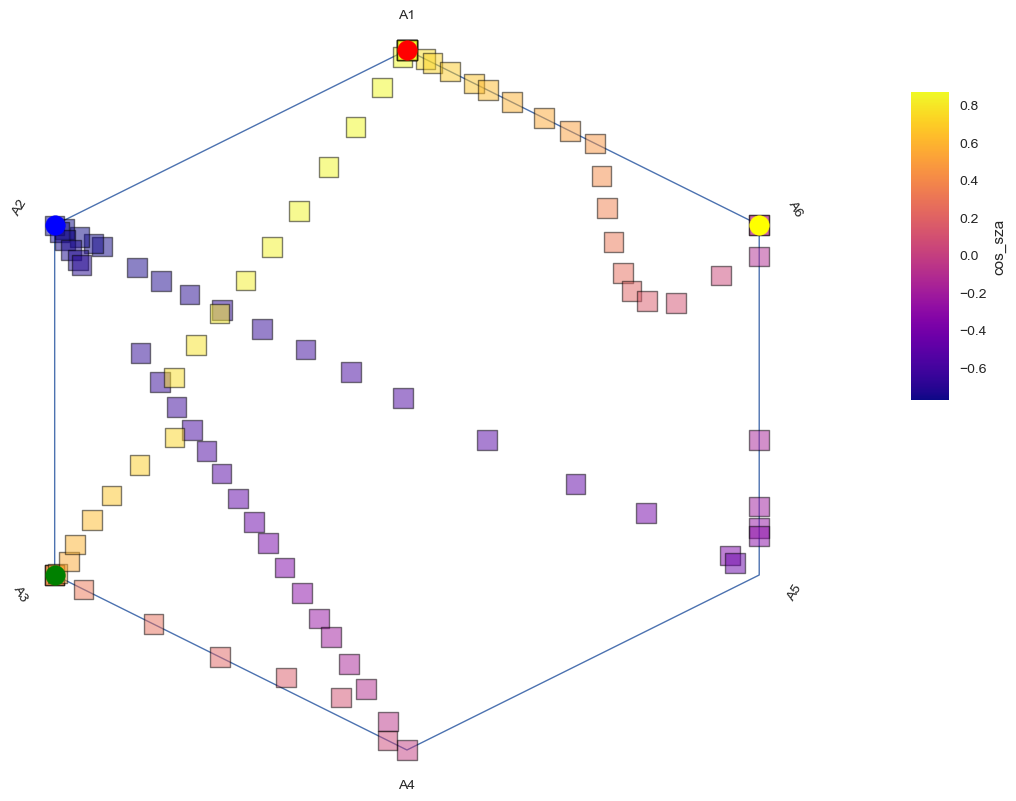

[[ 6.12323400e-17  1.00000000e+00]
 [-7.81831482e-01  6.23489802e-01]
 [-9.74927912e-01 -2.22520934e-01]
 [-4.33883739e-01 -9.00968868e-01]
 [ 4.33883739e-01 -9.00968868e-01]
 [ 9.74927912e-01 -2.22520934e-01]
 [ 7.81831482e-01  6.23489802e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


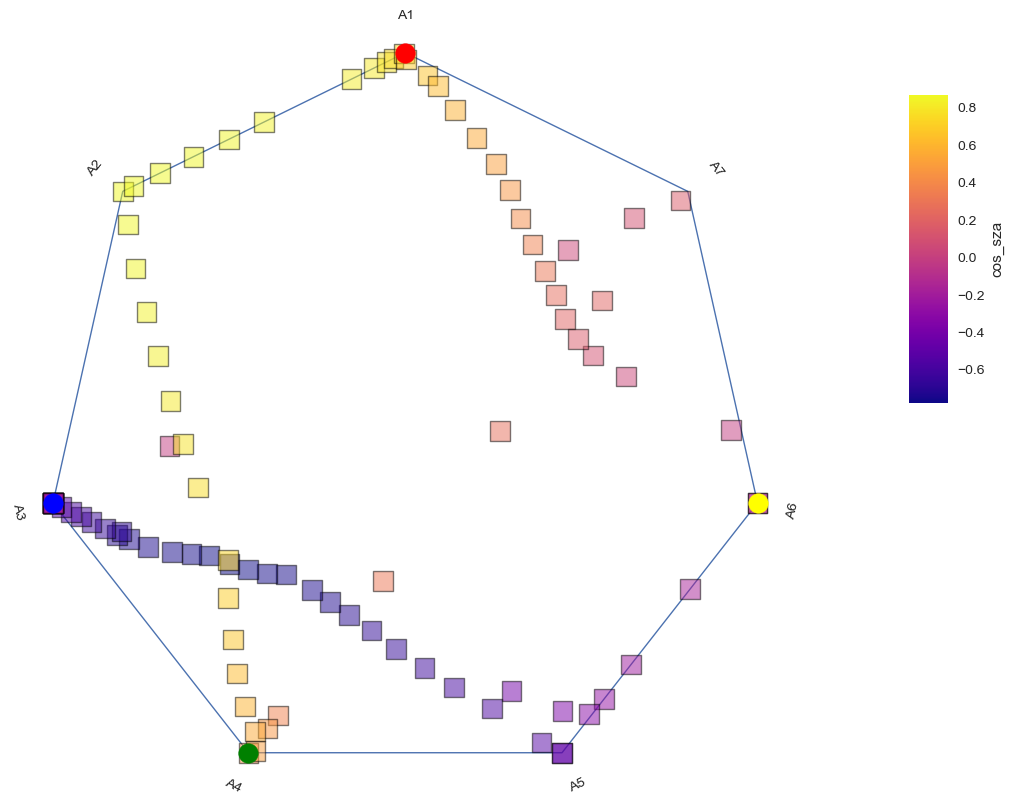

[[ 6.12323400e-17  1.00000000e+00]
 [-7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  1.22464680e-16]
 [-7.07106781e-01 -7.07106781e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01]
 [ 1.00000000e+00 -2.44929360e-16]
 [ 7.07106781e-01  7.07106781e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


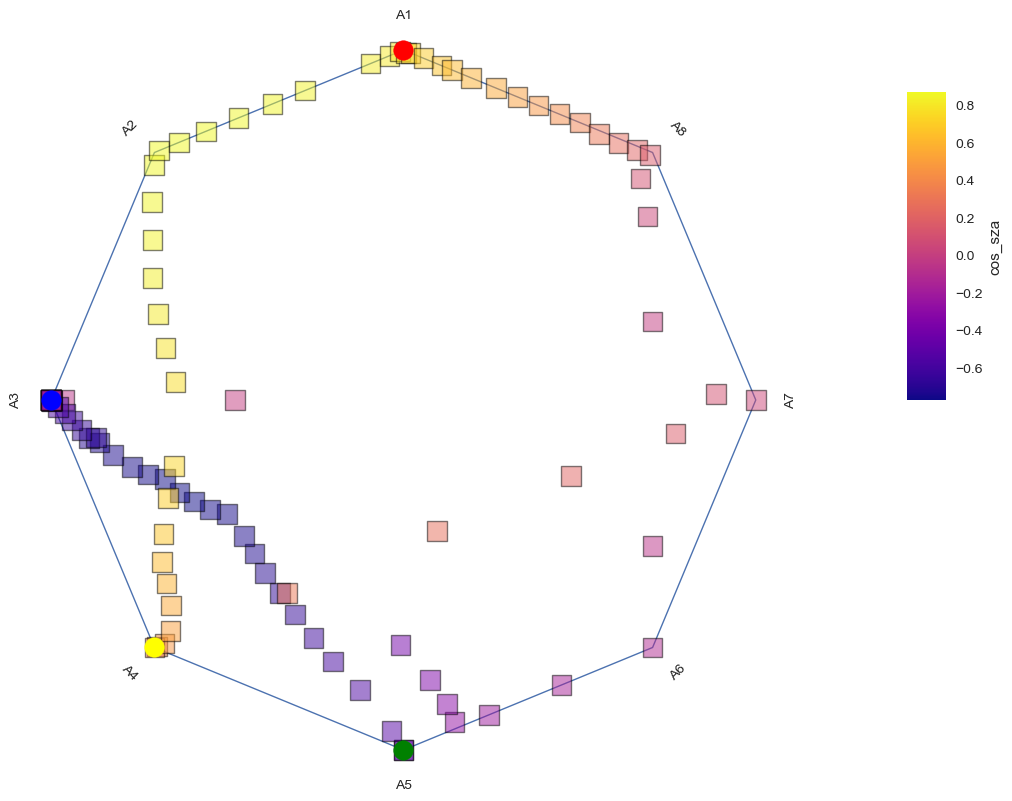

In [24]:
lst_feat = ['R' + str(i) for i in range(1,913+1)]

sc = StandardScaler()
X = April_L1_LA_rates_df[lst_feat].values #Using level1_df here
X_scaled = sc.fit_transform(X)

AA_list_la_l1_april=[]
lst_exp_var_la_l1_april = []
for i in range(3,9):
    AA = ArchetypalAnalysis(n_archetypes = i, 
                            tolerance = 0.001, 
                            max_iter = 200, 
                            random_state = 0, 
                            C = 0.0001, 
                            initialize = 'random',
                            redundancy_try = 30)
    AA.fit(X_scaled)
    AA_list_la_l1_april.append(AA)
    lst_exp_var_la_l1_april.append(AA.explained_variance_)
    
#explained variance
n_archs = list(range(3, 9))
plt.style.use('seaborn')
plt.plot(n_archs, lst_exp_var_la_l1_april, '-o')
plt.xlabel('Number of Archetypes')
plt.ylabel('Explained Variance')
plt.show()


#coloring - cosine zenith
legend_color = list(April_L1_LA_rates_df['cos_sza']) #get concentrations
plot_args = {'color':None, 's' : 200}
plot_args['edgecolor'] = 'black'  # Set the color of the marker border
plot_args['linewidth'] = 1  # Set the width of the marker border


#simplex plots    
flag = True
arr1 = AA_list_la_l1_april[1].archetypes.T
color_indices = []
for AA in AA_list_la_l1_april:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    if flag:
        flag = False
        plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, cmap='plasma', categorical=False, legend_color = legend_color, label = 'cos_sza')
    else:
        plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, cmap='plasma', categorical=False, legend_color = legend_color, label = 'cos_sza')

## Coloring by hour

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01 -5.00000000e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


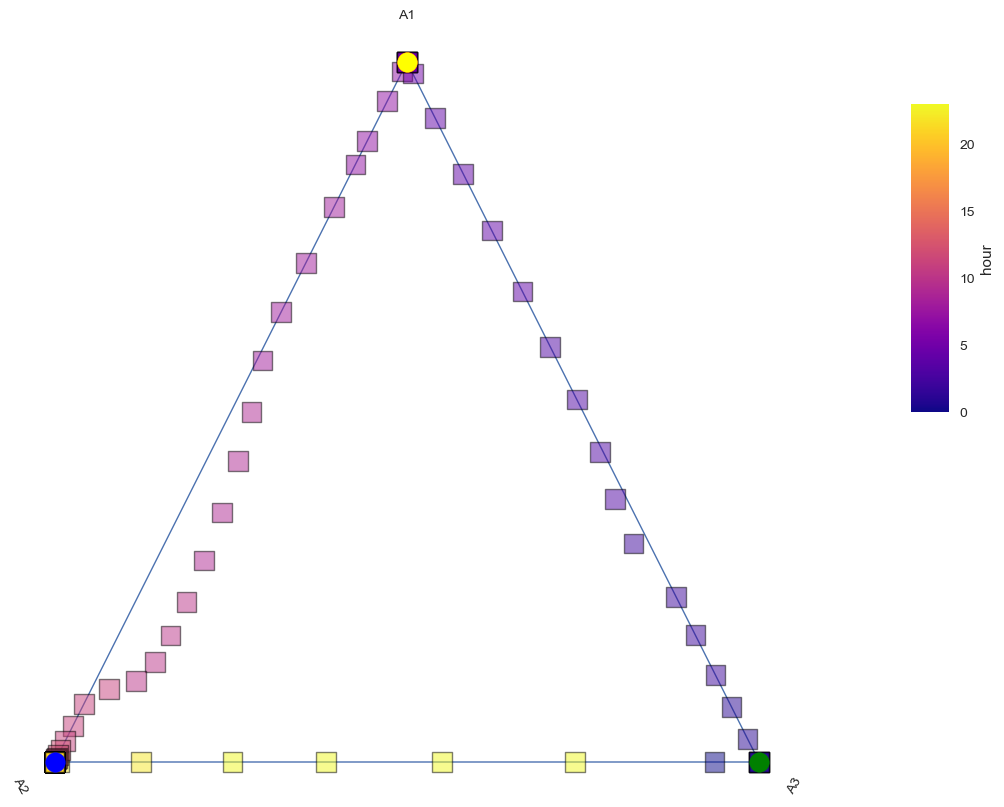

[[ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]
 [ 1.0000000e+00 -2.4492936e-16]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


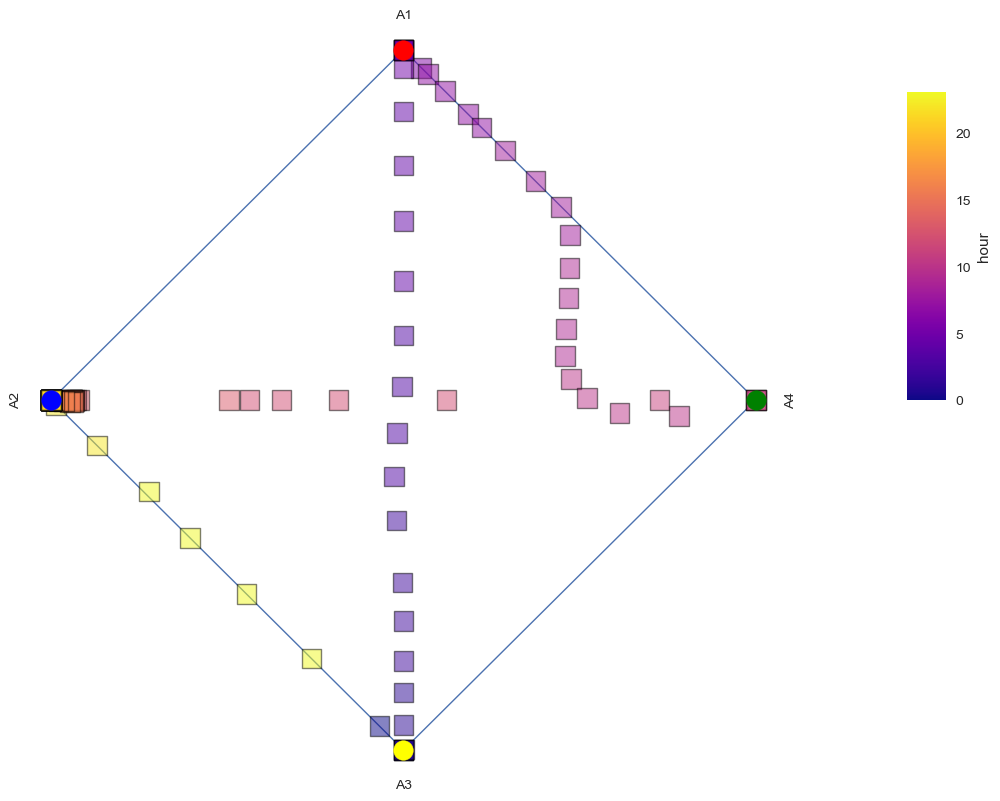

[[ 6.12323400e-17  1.00000000e+00]
 [-9.51056516e-01  3.09016994e-01]
 [-5.87785252e-01 -8.09016994e-01]
 [ 5.87785252e-01 -8.09016994e-01]
 [ 9.51056516e-01  3.09016994e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


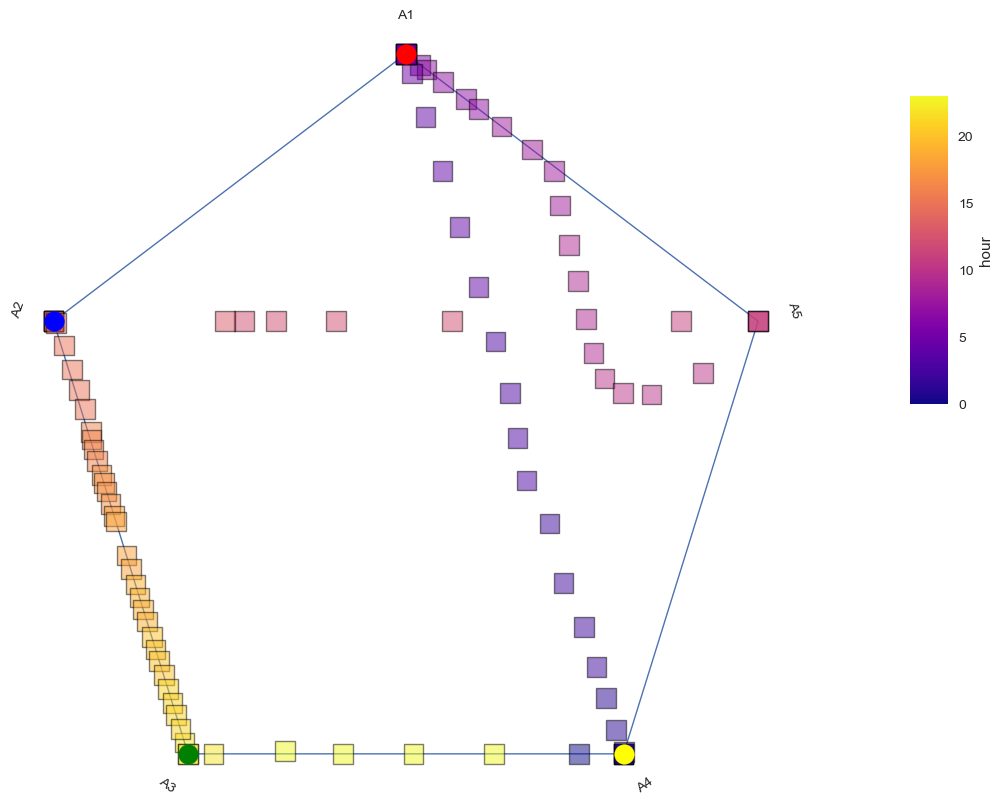

[[ 6.12323400e-17  1.00000000e+00]
 [-8.66025404e-01  5.00000000e-01]
 [-8.66025404e-01 -5.00000000e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 8.66025404e-01 -5.00000000e-01]
 [ 8.66025404e-01  5.00000000e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


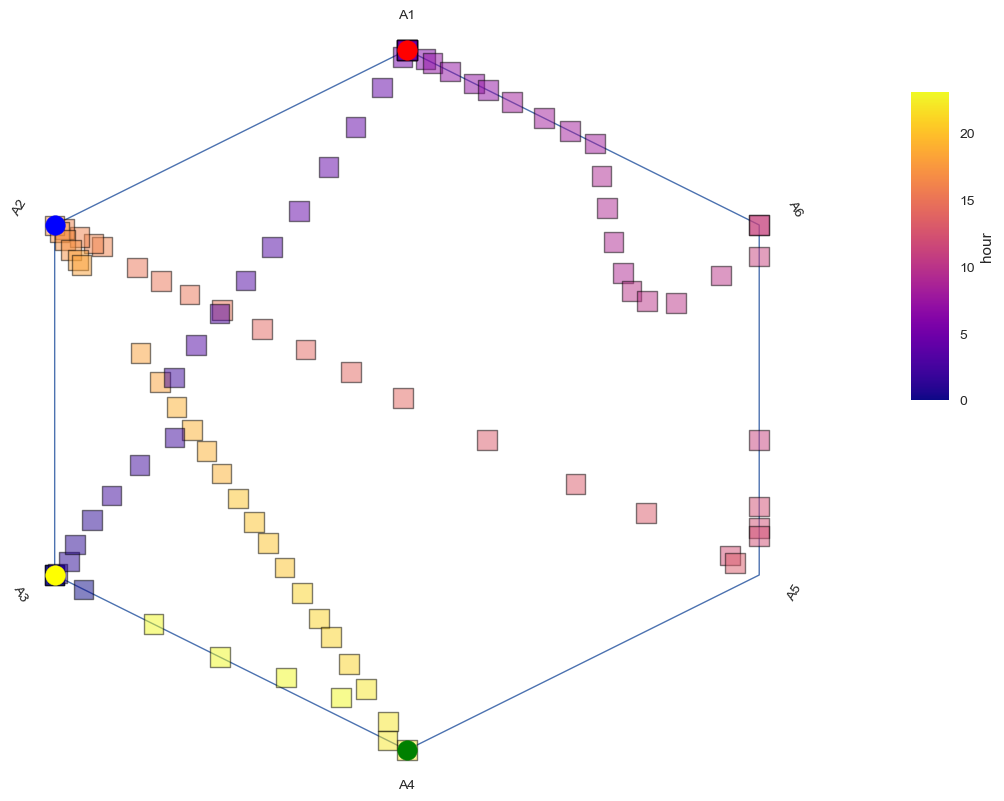

[[ 6.12323400e-17  1.00000000e+00]
 [-7.81831482e-01  6.23489802e-01]
 [-9.74927912e-01 -2.22520934e-01]
 [-4.33883739e-01 -9.00968868e-01]
 [ 4.33883739e-01 -9.00968868e-01]
 [ 9.74927912e-01 -2.22520934e-01]
 [ 7.81831482e-01  6.23489802e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


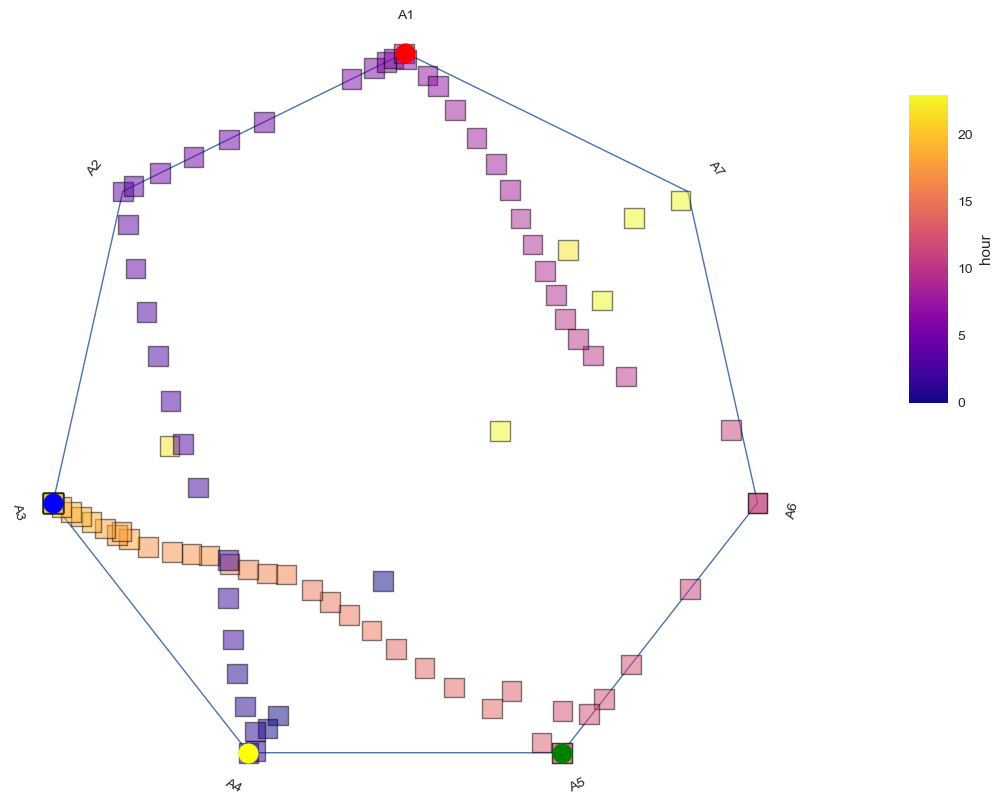

[[ 6.12323400e-17  1.00000000e+00]
 [-7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  1.22464680e-16]
 [-7.07106781e-01 -7.07106781e-01]
 [-1.83697020e-16 -1.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01]
 [ 1.00000000e+00 -2.44929360e-16]
 [ 7.07106781e-01  7.07106781e-01]]


C:\Users\nandy\AppData\Local\Temp\ipykernel_6844\3932072342.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


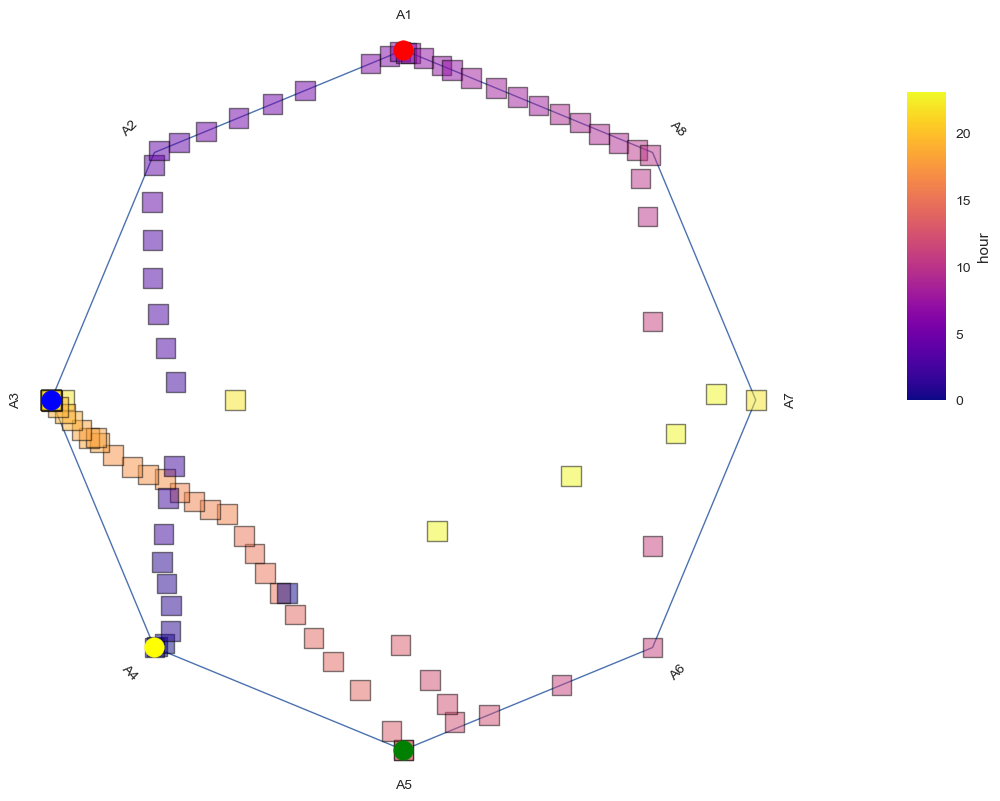

In [25]:
#coloring - cosine zenith
# legend_color = list(April_L1_LA_rates_df['cos_sza']) #get concentrations
legend_color = list(April_L1_LA_rates_df['timestamp'].dt.hour)
legend_color = [(i+9)%24 for i in legend_color]
# plot_args = {'color':None}
plot_args = {'color':None, 's' : 200}
plot_args['edgecolor'] = 'black'  # Set the color of the marker border
plot_args['linewidth'] = 1  # Set the width of the marker border

#simplex plots    
flag = True
arr1 = AA_list_la_l1_april[0].archetypes.T
color_indices = []
for AA in AA_list_la_l1_april:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True, cmap='plasma', categorical=False, legend_color = legend_color, label = 'hour')